In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse 
from google.colab import drive
import pprint
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data_dir='/content/gdrive/MyDrive/data2/'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 20,
                                             shuffle=True, num_workers= 0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  


In [11]:
print(image_datasets)
print("**************")
pprint.pprint(dataloaders)

{'train': Dataset ImageFolder
    Number of datapoints: 2420
    Root location: /content/gdrive/MyDrive/data2/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3100
    Root location: /content/gdrive/MyDrive/data2/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
**************
{'test': <torch.utils.data.dataloader.DataLoader object at 0x7f13be54c690>,
 'train': <torch.utils.d

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        im = Image.open(os.path.join(folder,filename))
        img = cv2.imread(os.path.join(folder,filename))
        if im is not None:
            images.append(im)
    return images

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_time= time.time()
epochs = 100
batch_size =20 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:
sm = torch.nn.Softmax()

In [ ]:
def testmodel(testimage , cut_off_threshold):
  print('test size is : ' ,len(testimage) , 'sample')
  coivdpred = list()
  noncovidpred = list()
  totalpred = list()
  grandth = list()

  for  inputs, labels in testimage :
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob2 = sm(out)

    if float(cur_prob2[0][0])> cut_off_threshold:
      out2 = 0 
      coivdpred.append(0)
      totalpred.append(out2)
      grandth.append(labels)

    else:
      out2 = 1 
      totalpred.append(out2)
      noncovidpred.append(1)
      grandth.append(labels)

  covid_prob = list() 
  non_prob = list()
  for  inputs, labels in testimage:
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob = sm(out)
    if labels == 0 :
        covid_prob.append(cur_prob.data.numpy()[0,0])
    if labels == 1 :
        non_prob.append(cur_prob.data.numpy()[0,0])
  k = 0
  for i in range(3100):
    if grandth[i] == 0 :
      if totalpred[i] == 1:
        k = k+1
  print('num of samples covid but predicted non covid :' ,k)
  l = 0
  for i in range(3100):
    if grandth[i] == 1 :
      if totalpred[i] == 0:
        l = l+1
  print('num of samples non covid but predicted covid :' , l)
  print('total cases that predicted as covid: ' , len(coivdpred))
  sensivity = (100 - k) / 100
  print('total cases that predicted as non covid :' ,len(noncovidpred))
  Specificity =  (3000 - l) / 3000
  print('Sensitivity is :',sensivity)
  print('Specificity is :', Specificity)
  ConfusionMatrix(totalpred , grandth)
  return covid_prob , non_prob ,coivdpred , noncovidpred


In [ ]:
def Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, cut_off_threshold):
  y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
  y_pred_res18= [1 for i in range(len(coivdpred))]+[0 for i in range(len(noncovidpred))]

           
  auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
  ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

  plt.figure()
  pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='   AUC= %.3f'   %auc_res18) 
  pyplot.ylim([0,1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title("ROC Curve threshold is %.2f "  %cut_off_threshold)
  pyplot.legend(loc='lower right')
  # plt.savefig('./ROC_covid19.png') 

In [ ]:
def Probabilties(covid_prob ,non_prob ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')
  plt.savefig('./scores_histogram.png')

In [ ]:
def ConfusionMatrix(totalpred , grandth):
  y_pred= np.asarray(totalpred, dtype=np.int64)
  y_test= np.asarray(grandth, dtype=np.int64)
  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   
  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])
  ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['COVID','Non-COVID'], yticklabels= ['COVID','Non-COVID'])
  ax.set_title("Confusion matrix")



# **DATA AG**

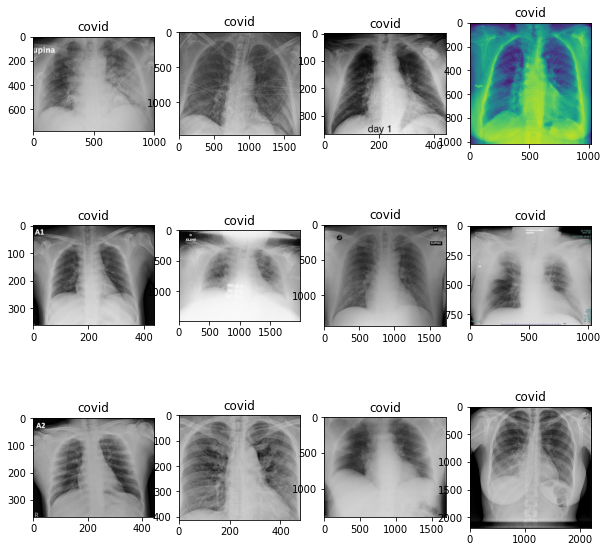

In [ ]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(train_covid[i])
plt.show()  # display it

In [ ]:
transforms1 = transforms.Compose([
        transforms.Resize((224,224)),
])

In [ ]:
print(train_covid[0].getbands())

('R', 'G', 'B')


In [ ]:
trainim_coivid = list()
for i in train_covid:
  j = transforms1(i)
  trainim_coivid.append(j)

In [ ]:
print(type(trainim_coivid))
print(len(trainim_coivid))
print(trainim_coivid[0].size)

<class 'list'>
84
(224, 224)


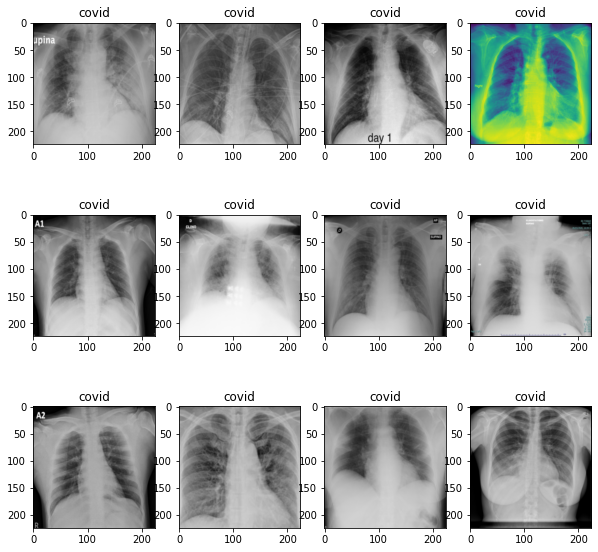

In [ ]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid[i])
plt.show()  # display it

In [ ]:
transforms2 = transforms.Compose([
        transforms.RandomRotation(20)
])

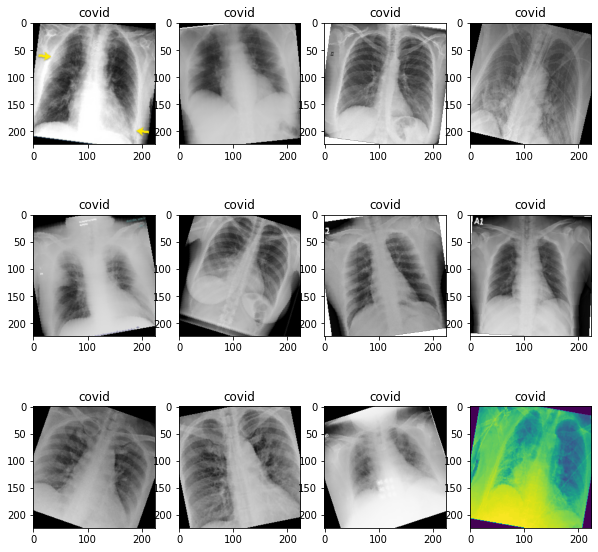

In [ ]:
trainim_coivid2 = list()
for i in trainim_coivid:
  j = transforms2(i)
  trainim_coivid2.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid2[i])
plt.show()  # display it

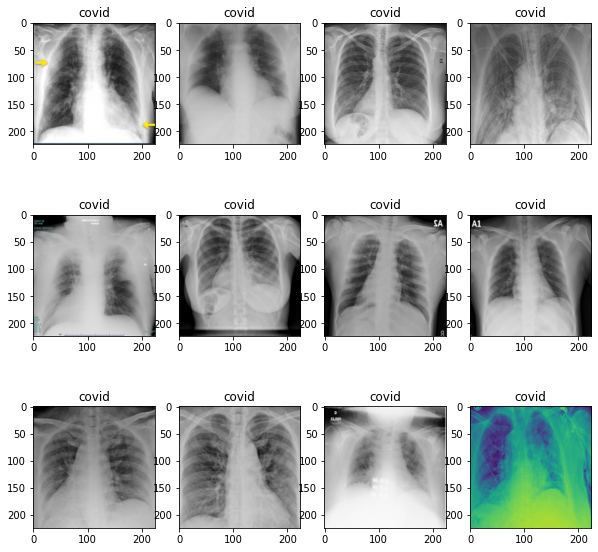

In [ ]:

transforms3 = transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip()
])
trainim_coivid3 = list()
for i in trainim_coivid:
  j = transforms3(i)
  trainim_coivid3.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid3[i])
plt.show()  # display it

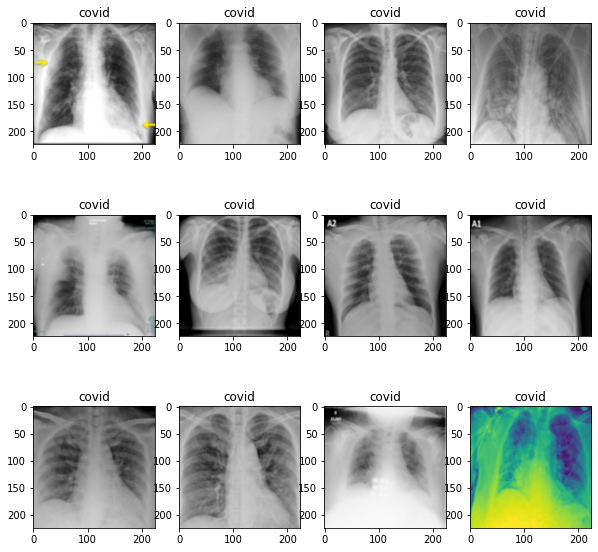

In [ ]:
transforms4 = transforms.Compose([
        transforms.GaussianBlur(kernel_size =3  ,sigma= 3.0)
])
trainim_coivid4 = list()
for i in trainim_coivid:
  j = transforms4(i)
  trainim_coivid4.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid4[i])
plt.show()  # display it

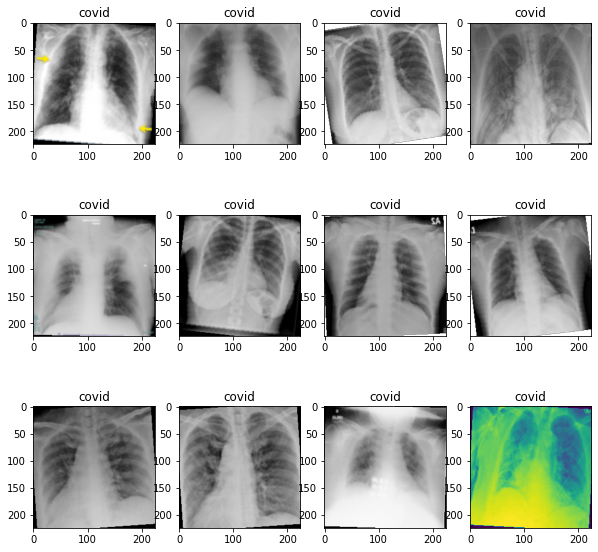

In [ ]:
transforms5 = transforms.Compose([
        transforms.GaussianBlur(kernel_size =3  ,sigma= 3.0),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10)
])
trainim_coivid5 = list()
for i in trainim_coivid:
  j = transforms5(i)
  trainim_coivid5.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid5[i])
plt.show()  # display it

In [ ]:
traincov_tot = trainim_coivid5 + trainim_coivid4 + trainim_coivid3 + trainim_coivid2 +trainim_coivid

420
<class 'list'>


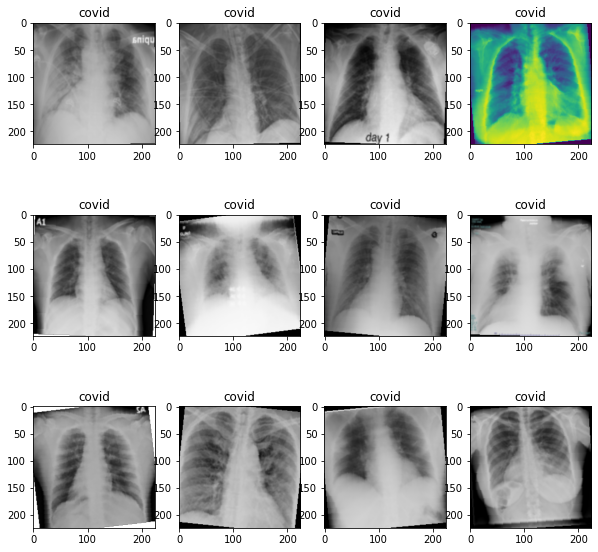

In [ ]:
print(len(traincov_tot))
print(type(traincov_tot))
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(traincov_tot[i])
plt.show()  # display it

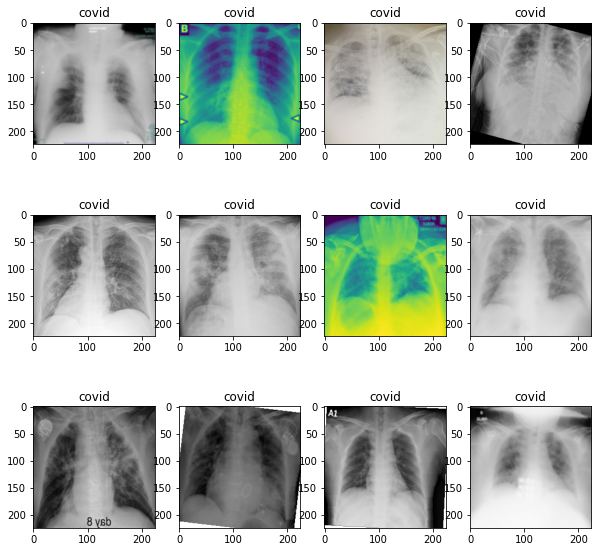

In [ ]:
random.shuffle(traincov_tot)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(traincov_tot[i])
plt.show()  # display it

In [ ]:
import time
i = 0
for item in traincov_tot:
  item.save('/content/gdrive/MyDrive/data/train/covid/{}.png'.format(i))
  time.sleep(0.2) # Sleep for 0.2 seconds
  print(i)
  i = i +1

In [ ]:
train_noncovid = load_images_from_folder('/content/gdrive/MyDrive/data/train/non')

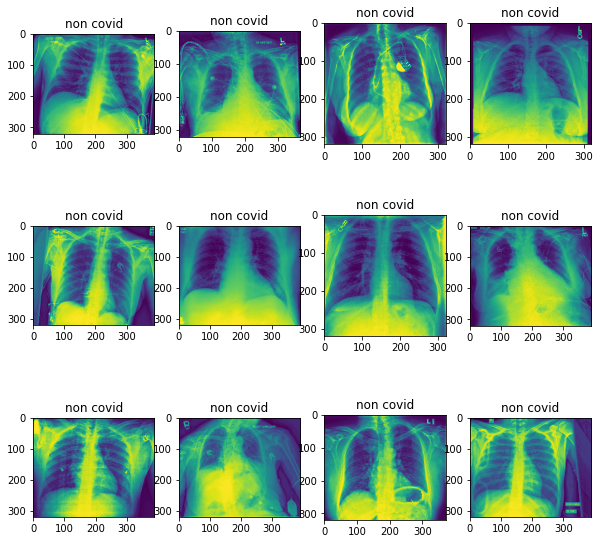

2000
<class 'list'>


In [ ]:

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('non covid')
    plt.imshow(train_noncovid[i])
plt.show()  # display it


print(len(train_noncovid))
print(type(train_noncovid))

# **RESNET 18**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './content/gdrive/MyDrive/covid_resnet18_epoch%d.pt' %epochs )


end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/1
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 1-th batch (size=20), train acc= 0.100 


preds: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 2-th batch (size=20), train acc= 0.250 


preds: tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0])
label: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])
1-th epoch, 3-th batch (size=20), train acc= 0.700 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
1-th epoch, 4-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])
1-th epoch, 5-th batch 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/data/covid_resnet18_epoch100.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experiments**

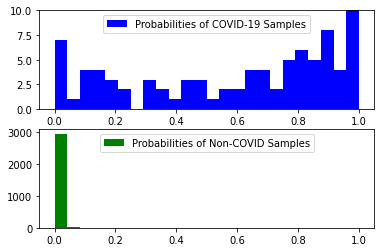

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 74
total cases that predicted as covid:  168
total cases that predicted as non covid : 2932
Sensitivity is : 0.94
Specificity is : 0.9753333333333334


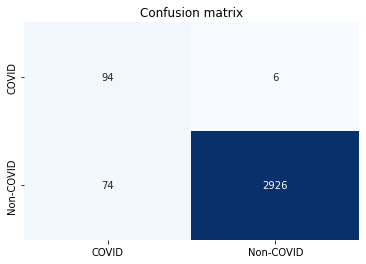

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

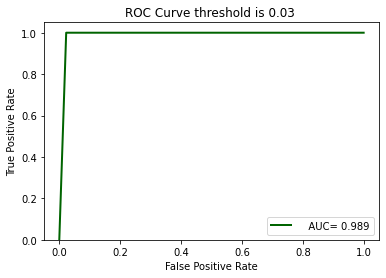

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 24
total cases that predicted as covid:  114
total cases that predicted as non covid : 2986
Sensitivity is : 0.9
Specificity is : 0.992


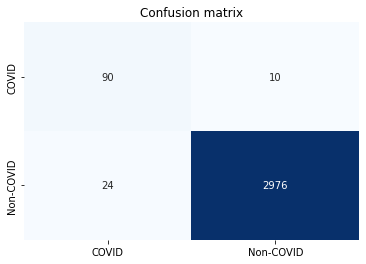

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

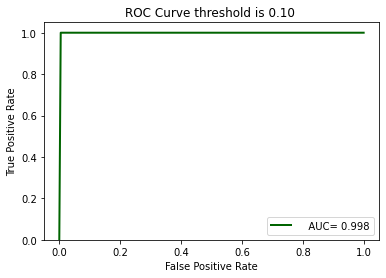

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 14
num of samples non covid but predicted covid : 17
total cases that predicted as covid:  103
total cases that predicted as non covid : 2997
Sensitivity is : 0.86
Specificity is : 0.9943333333333333


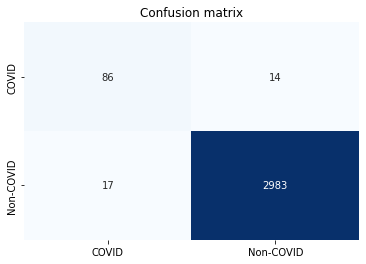

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

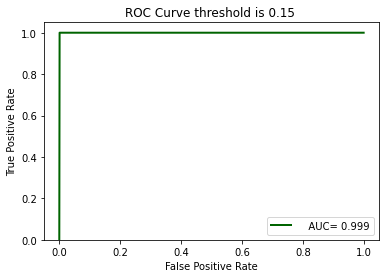

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 14
total cases that predicted as covid:  97
total cases that predicted as non covid : 3003
Sensitivity is : 0.83
Specificity is : 0.9953333333333333


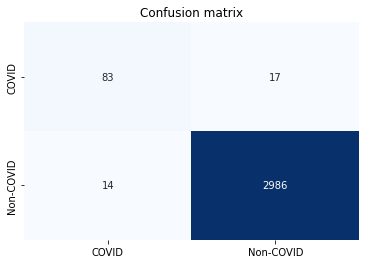

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

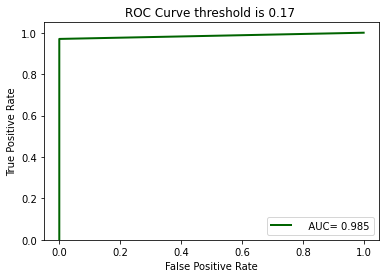

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 14
total cases that predicted as covid:  96
total cases that predicted as non covid : 3004
Sensitivity is : 0.82
Specificity is : 0.9953333333333333


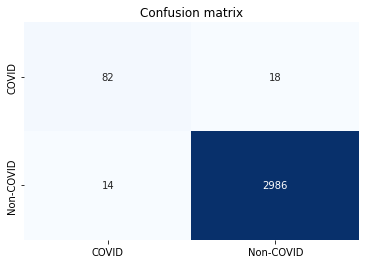

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

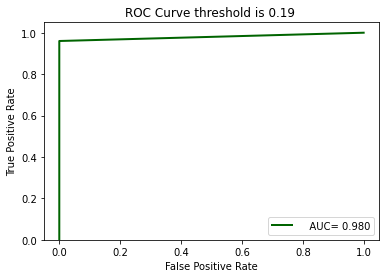

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.20**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 13
total cases that predicted as covid:  94
total cases that predicted as non covid : 3006
Sensitivity is : 0.81
Specificity is : 0.9956666666666667


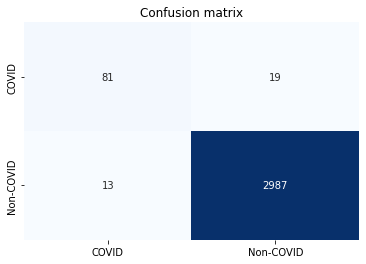

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

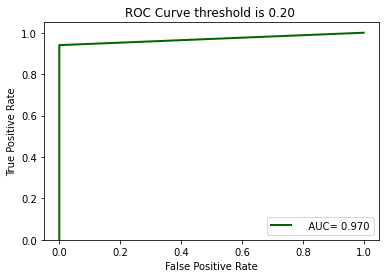

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  86
total cases that predicted as non covid : 3014
Sensitivity is : 0.79
Specificity is : 0.9976666666666667


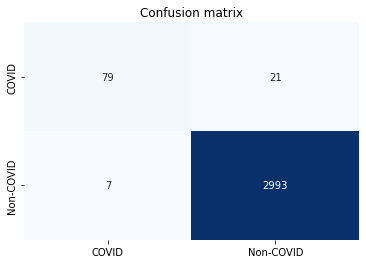

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

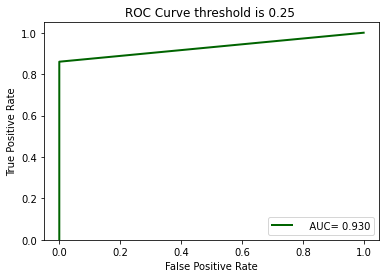

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  81
total cases that predicted as non covid : 3019
Sensitivity is : 0.77
Specificity is : 0.9986666666666667


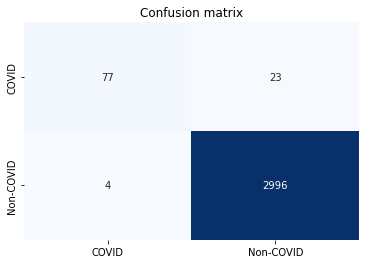

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

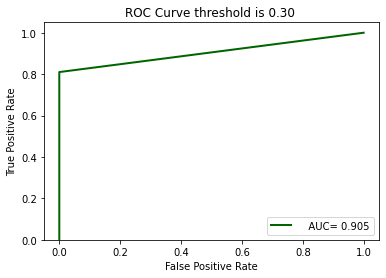

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 24
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  79
total cases that predicted as non covid : 3021
Sensitivity is : 0.76
Specificity is : 0.999


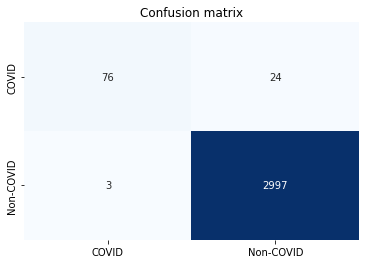

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

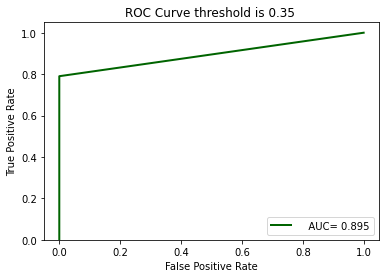

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 26
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  76
total cases that predicted as non covid : 3024
Sensitivity is : 0.74
Specificity is : 0.9993333333333333


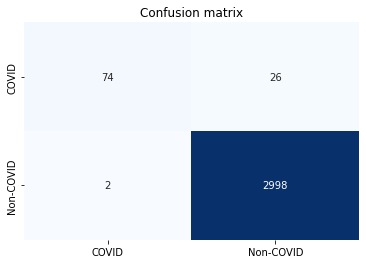

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

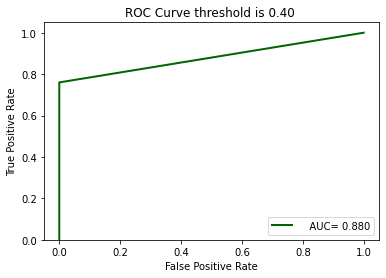

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 33
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  69
total cases that predicted as non covid : 3031
Sensitivity is : 0.67
Specificity is : 0.9993333333333333


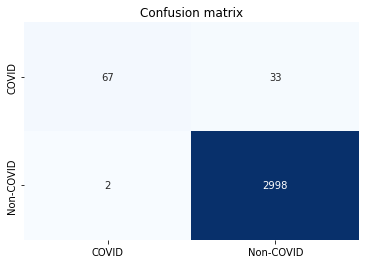

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

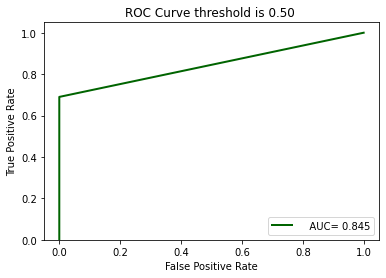

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **2nd ResNet18**

## **code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet18(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        print(child , i)
        if i >= 8 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet18_100_3.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 2
ReLU(inplace=True) 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 4
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.900 


preds: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 1.000 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet18_100_3.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experiment**

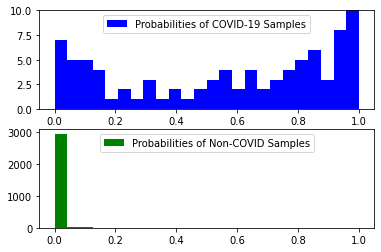

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 5
num of samples non covid but predicted covid : 74
total cases that predicted as covid:  169
total cases that predicted as non covid : 2931
Sensitivity is : 0.95
Specificity is : 0.9753333333333334


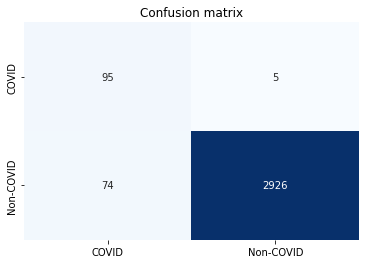

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

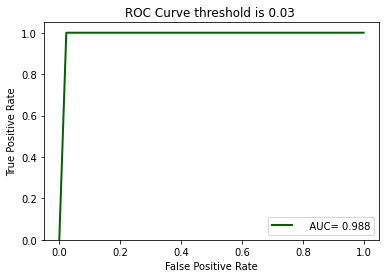

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 13
num of samples non covid but predicted covid : 17
total cases that predicted as covid:  104
total cases that predicted as non covid : 2996
Sensitivity is : 0.87
Specificity is : 0.9943333333333333


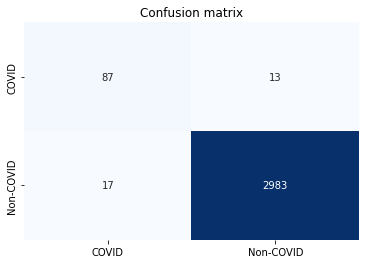

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

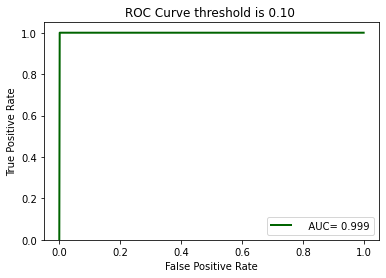

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 12
total cases that predicted as covid:  94
total cases that predicted as non covid : 3006
Sensitivity is : 0.82
Specificity is : 0.996


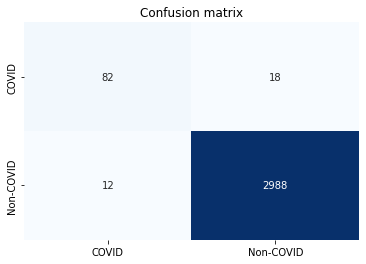

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

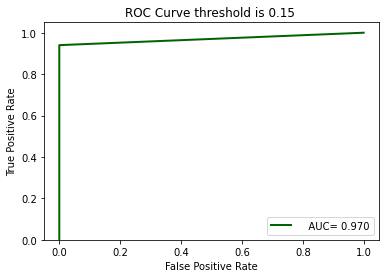

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 11
total cases that predicted as covid:  90
total cases that predicted as non covid : 3010
Sensitivity is : 0.79
Specificity is : 0.9963333333333333


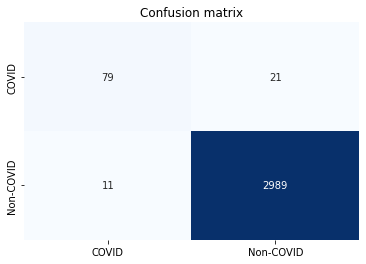

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

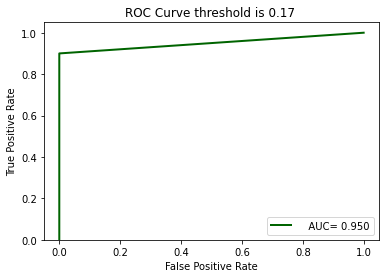

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  87
total cases that predicted as non covid : 3013
Sensitivity is : 0.78
Specificity is : 0.997


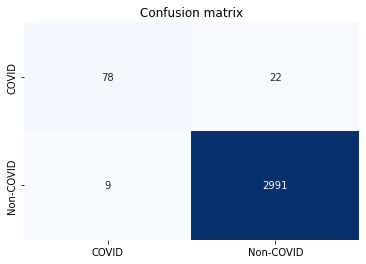

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

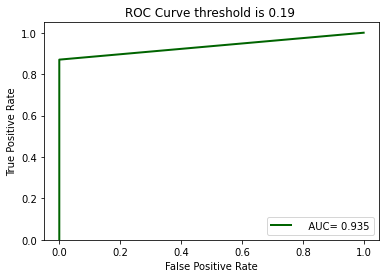

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.20**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  87
total cases that predicted as non covid : 3013
Sensitivity is : 0.78
Specificity is : 0.997


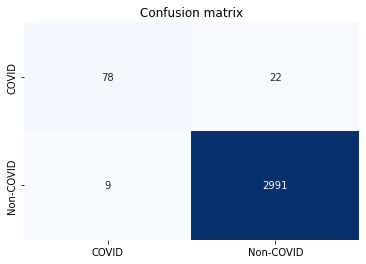

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

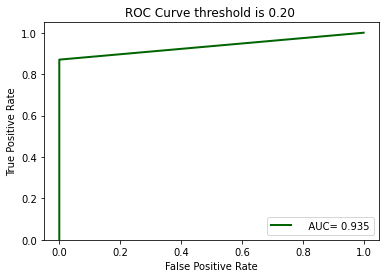

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 24
num of samples non covid but predicted covid : 5
total cases that predicted as covid:  81
total cases that predicted as non covid : 3019
Sensitivity is : 0.76
Specificity is : 0.9983333333333333


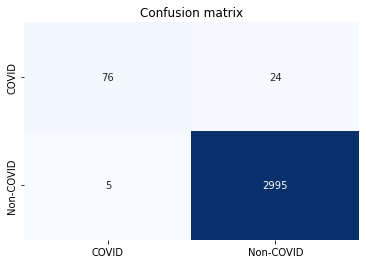

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

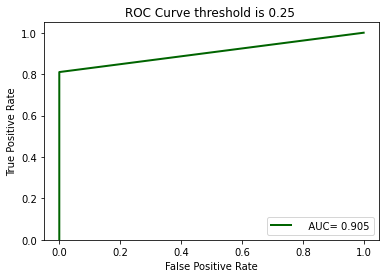

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 5
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.75
Specificity is : 0.9983333333333333


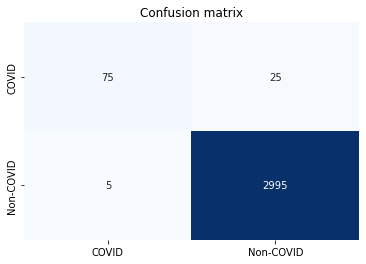

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

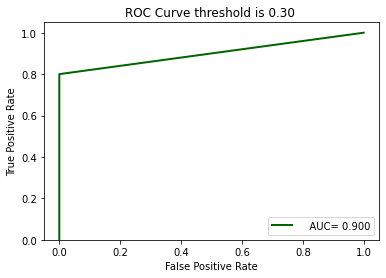

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 28
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  75
total cases that predicted as non covid : 3025
Sensitivity is : 0.72
Specificity is : 0.999


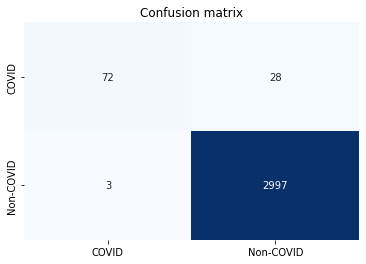

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

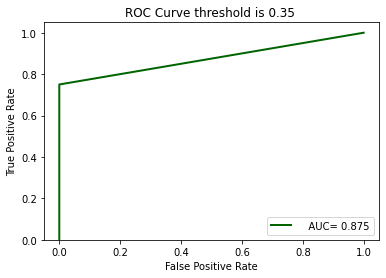

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 31
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  71
total cases that predicted as non covid : 3029
Sensitivity is : 0.69
Specificity is : 0.9993333333333333


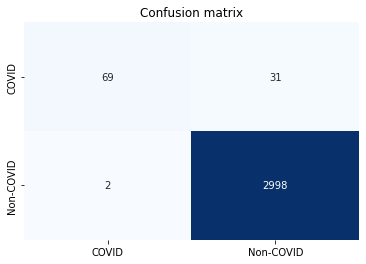

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

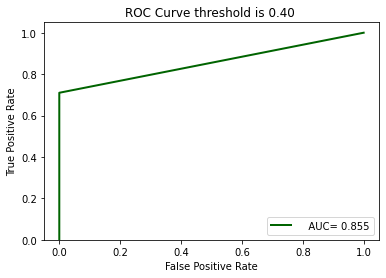

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 34
num of samples non covid but predicted covid : 1
total cases that predicted as covid:  67
total cases that predicted as non covid : 3033
Sensitivity is : 0.66
Specificity is : 0.9996666666666667


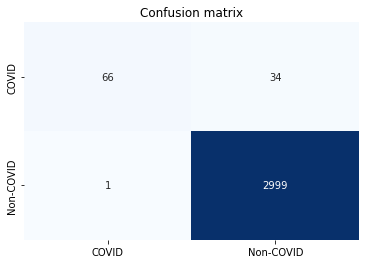

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

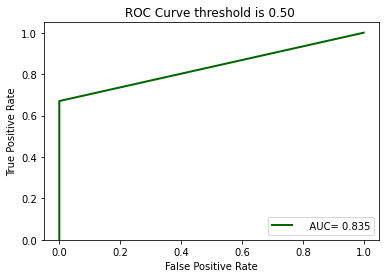

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **3rd ResNet18**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet18(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        if i >= 7 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet18_100_2.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 1.000 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet18_100_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experiments**

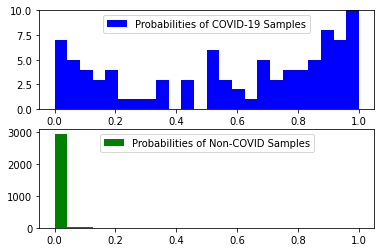

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 7
num of samples non covid but predicted covid : 46
total cases that predicted as covid:  139
total cases that predicted as non covid : 2961
Sensitivity is : 0.93
Specificity is : 0.9846666666666667


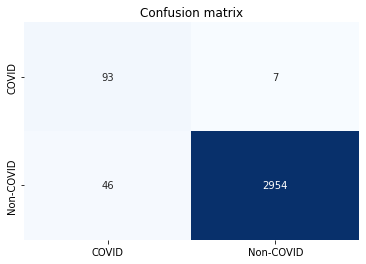

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

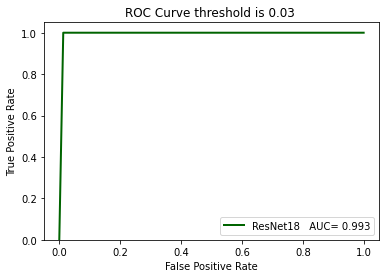

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 12
num of samples non covid but predicted covid : 16
total cases that predicted as covid:  104
total cases that predicted as non covid : 2996
Sensitivity is : 0.88
Specificity is : 0.9946666666666667


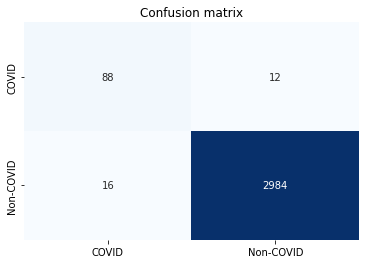

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

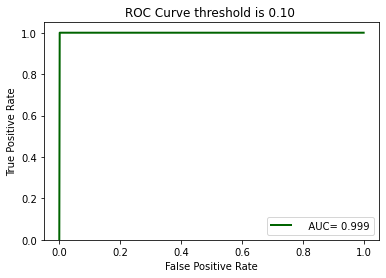

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.82
Specificity is : 0.998


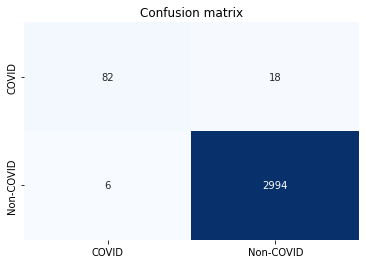

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

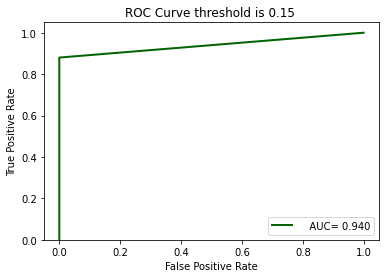

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 5
total cases that predicted as covid:  86
total cases that predicted as non covid : 3014
Sensitivity is : 0.81
Specificity is : 0.9983333333333333


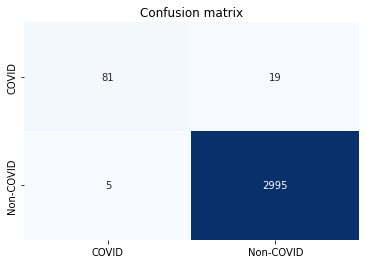

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

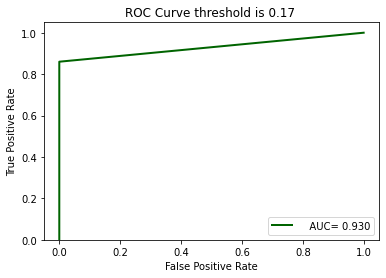

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  81
total cases that predicted as non covid : 3019
Sensitivity is : 0.77
Specificity is : 0.9986666666666667


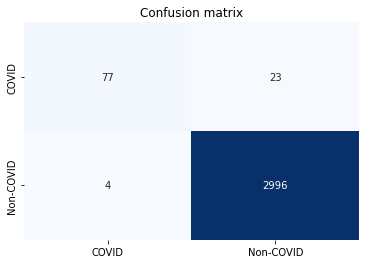

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

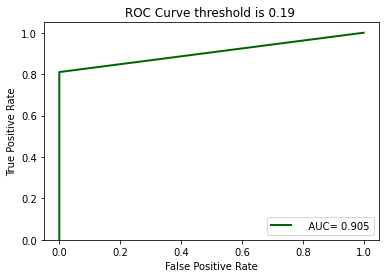

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.20**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  81
total cases that predicted as non covid : 3019
Sensitivity is : 0.77
Specificity is : 0.9986666666666667


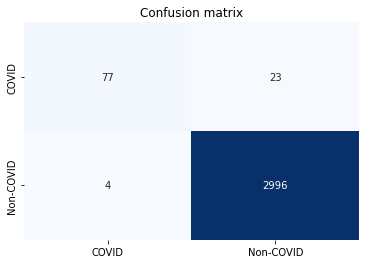

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

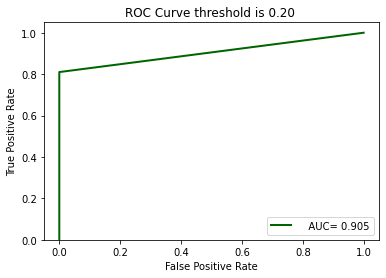

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 24
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  79
total cases that predicted as non covid : 3021
Sensitivity is : 0.76
Specificity is : 0.999


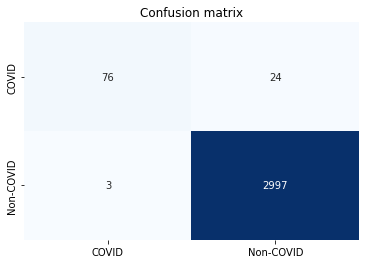

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

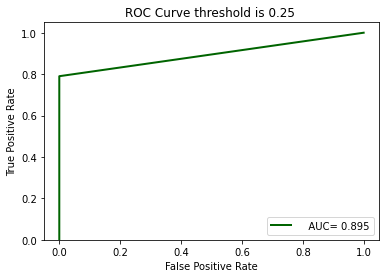

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.30**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 26
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  76
total cases that predicted as non covid : 3024
Sensitivity is : 0.74
Specificity is : 0.9993333333333333


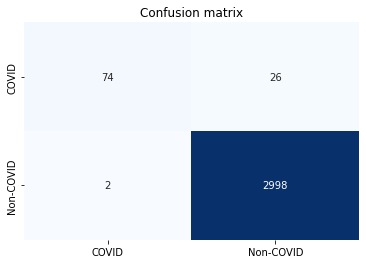

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

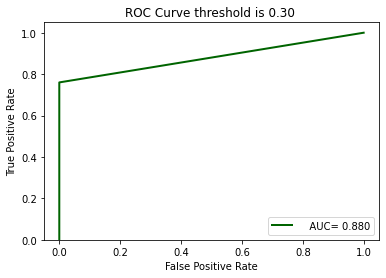

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 27
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  75
total cases that predicted as non covid : 3025
Sensitivity is : 0.73
Specificity is : 0.9993333333333333


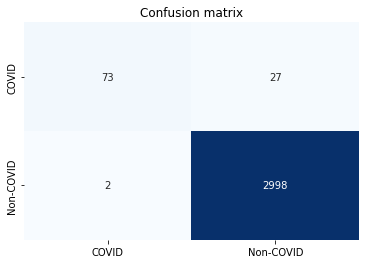

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

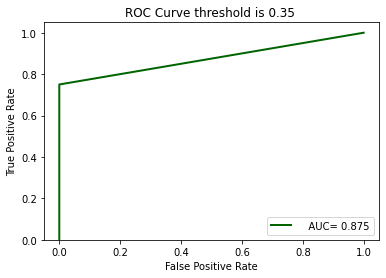

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.40**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 29
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  73
total cases that predicted as non covid : 3027
Sensitivity is : 0.71
Specificity is : 0.9993333333333333


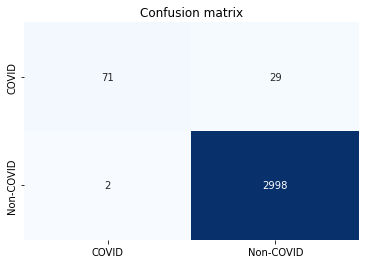

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

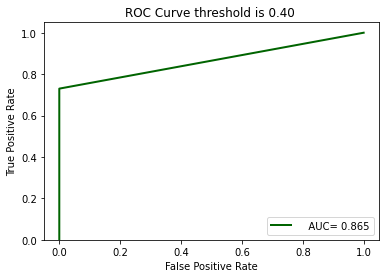

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 32
num of samples non covid but predicted covid : 1
total cases that predicted as covid:  69
total cases that predicted as non covid : 3031
Sensitivity is : 0.68
Specificity is : 0.9996666666666667


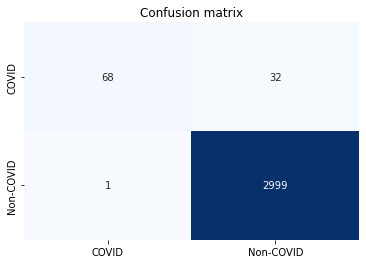

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

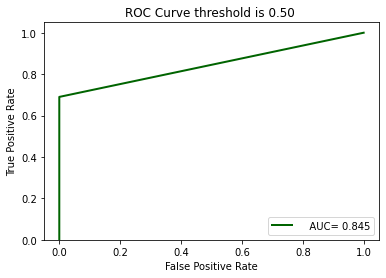

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **ResNet50**

## **Code**

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)

i = 0 
for child  in model_conv.children():
        i = i +1
        print(child , i)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 2
ReLU(inplace=True) 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [ ]:
#### load model
from torchsummary import summary
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resenet121_epoch100.pt')




Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
preds: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.850 


preds: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
  

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resenet121_epoch100.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']
class_names2 =  ['non','covid']

## **Experiments**

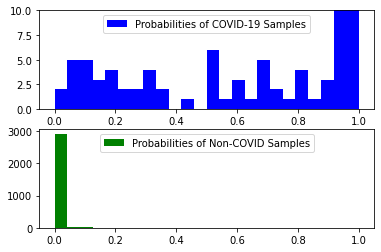

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 1
num of samples non covid but predicted covid : 107
total cases that predicted as covid:  206
total cases that predicted as non covid : 2894
Sensitivity is : 0.99
Specificity is : 0.9643333333333334


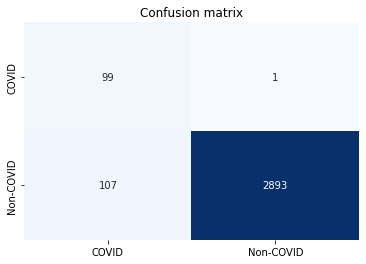

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

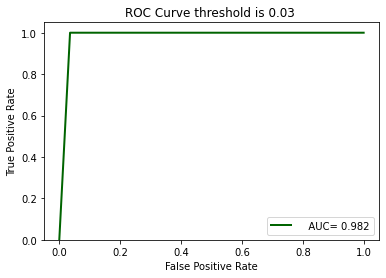

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 7
num of samples non covid but predicted covid : 24
total cases that predicted as covid:  117
total cases that predicted as non covid : 2983
Sensitivity is : 0.93
Specificity is : 0.992


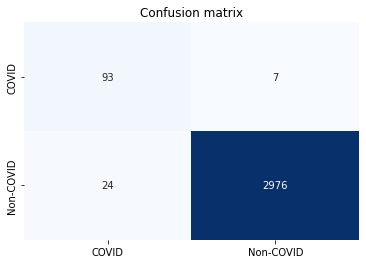

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

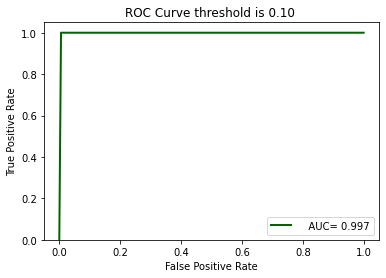

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 13
num of samples non covid but predicted covid : 15
total cases that predicted as covid:  102
total cases that predicted as non covid : 2998
Sensitivity is : 0.87
Specificity is : 0.995


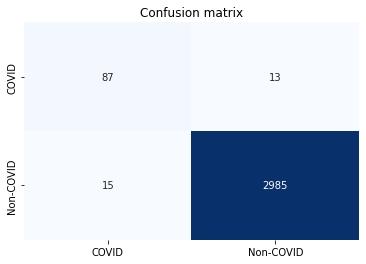

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

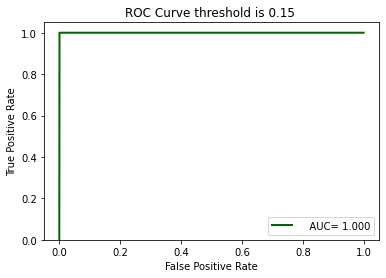

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 11
total cases that predicted as covid:  96
total cases that predicted as non covid : 3004
Sensitivity is : 0.85
Specificity is : 0.9963333333333333


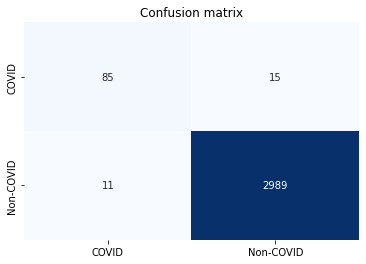

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

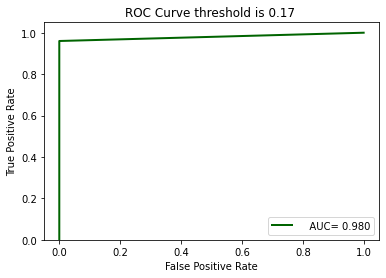

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.83
Specificity is : 0.9973333333333333


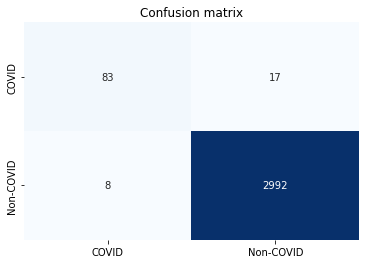

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

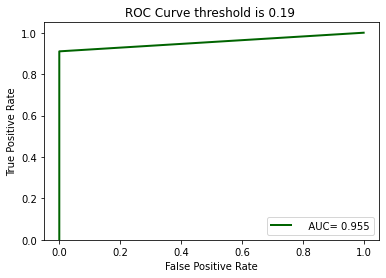

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.81
Specificity is : 0.9976666666666667


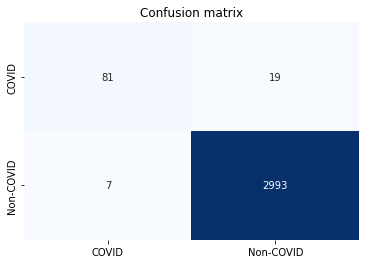

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

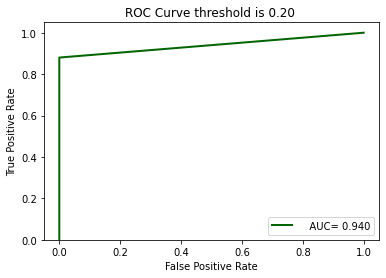

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  83
total cases that predicted as non covid : 3017
Sensitivity is : 0.79
Specificity is : 0.9986666666666667


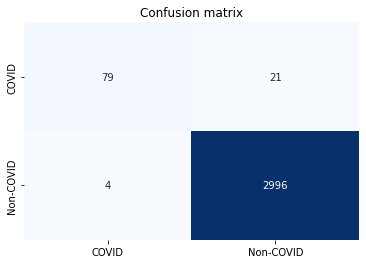

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

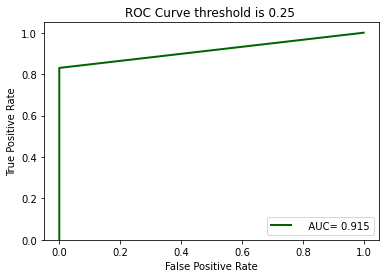

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 24
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.76
Specificity is : 0.9993333333333333


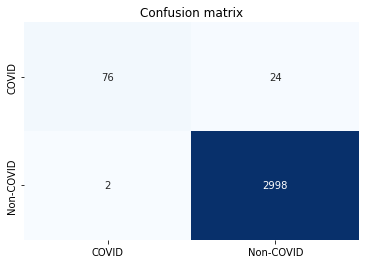

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

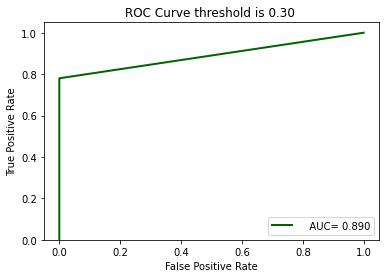

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 28
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  74
total cases that predicted as non covid : 3026
Sensitivity is : 0.72
Specificity is : 0.9993333333333333


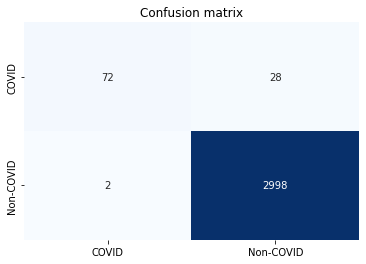

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

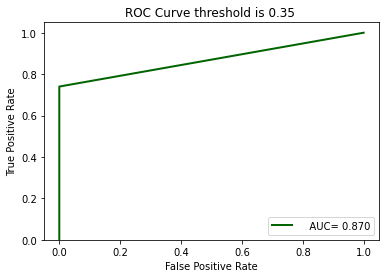

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 29
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  73
total cases that predicted as non covid : 3027
Sensitivity is : 0.71
Specificity is : 0.9993333333333333


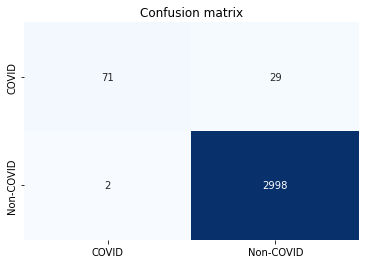

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

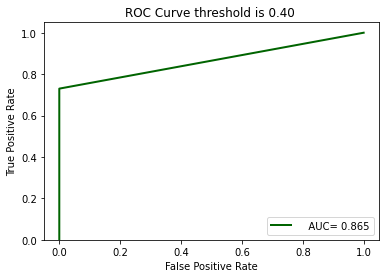

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 30
num of samples non covid but predicted covid : 1
total cases that predicted as covid:  71
total cases that predicted as non covid : 3029
Sensitivity is : 0.7
Specificity is : 0.9996666666666667


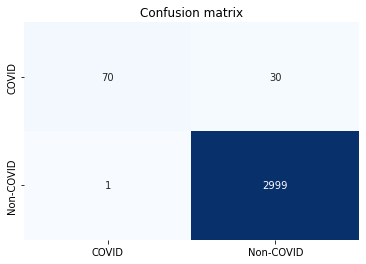

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

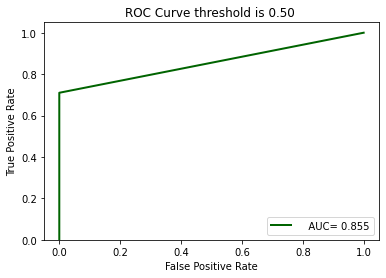

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.5)

# **2nd ResNet 50**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet50(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        if i >= 8 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# from torchsummary import summary

# summary(model_conv, (3, 224, 224))
if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet50_100_2.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 0.950 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet50_100_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experiments**

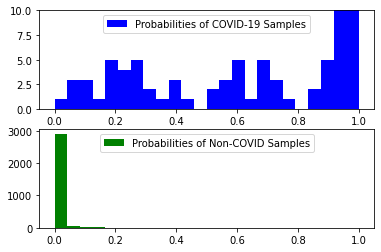

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 0
num of samples non covid but predicted covid : 144
total cases that predicted as covid:  244
total cases that predicted as non covid : 2856
Sensitivity is : 1.0
Specificity is : 0.952


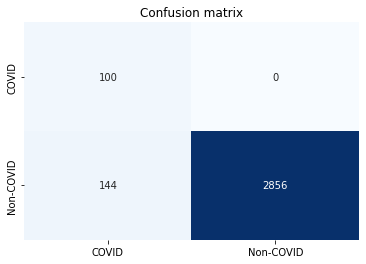

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

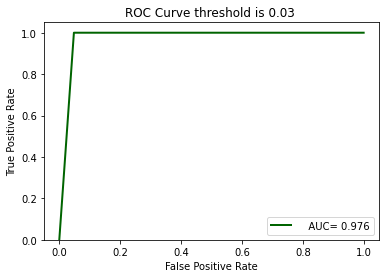

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 41
total cases that predicted as covid:  135
total cases that predicted as non covid : 2965
Sensitivity is : 0.94
Specificity is : 0.9863333333333333


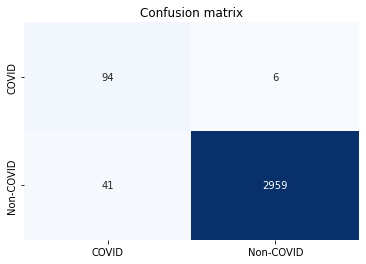

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

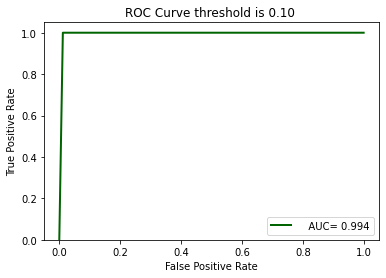

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 24
total cases that predicted as covid:  116
total cases that predicted as non covid : 2984
Sensitivity is : 0.92
Specificity is : 0.992


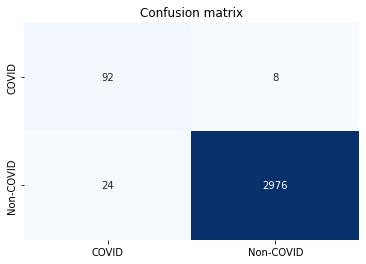

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

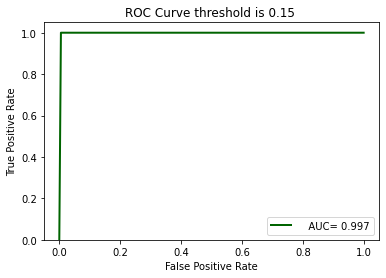

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 18
total cases that predicted as covid:  110
total cases that predicted as non covid : 2990
Sensitivity is : 0.92
Specificity is : 0.994


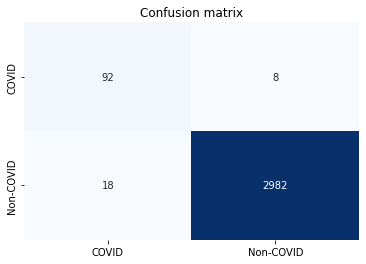

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

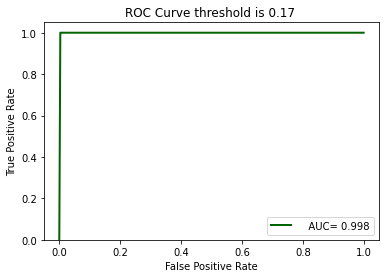

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 16
total cases that predicted as covid:  106
total cases that predicted as non covid : 2994
Sensitivity is : 0.9
Specificity is : 0.9946666666666667


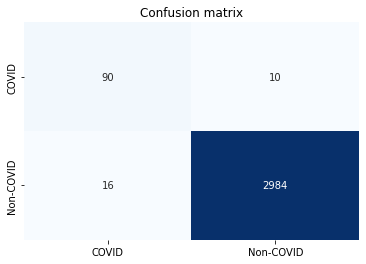

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

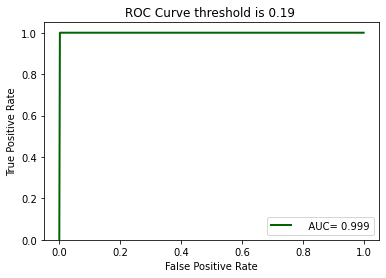

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 12
num of samples non covid but predicted covid : 13
total cases that predicted as covid:  101
total cases that predicted as non covid : 2999
Sensitivity is : 0.88
Specificity is : 0.9956666666666667


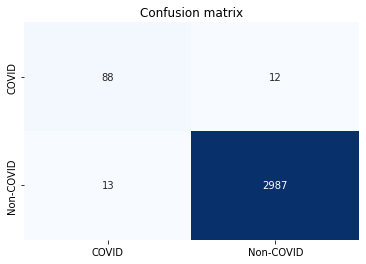

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

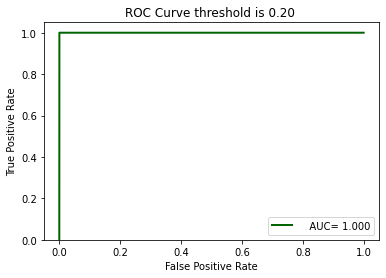

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  90
total cases that predicted as non covid : 3010
Sensitivity is : 0.83
Specificity is : 0.9976666666666667


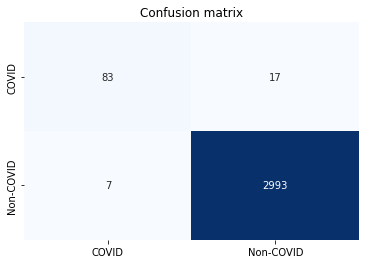

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

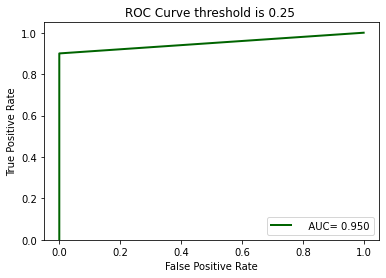

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.78
Specificity is : 0.9976666666666667


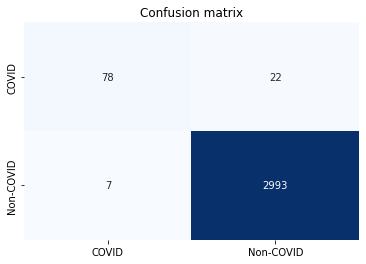

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

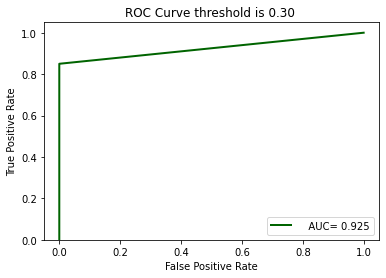

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.75
Specificity is : 0.999


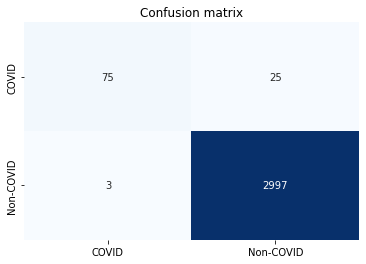

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

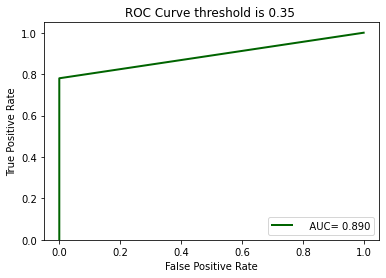

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.75
Specificity is : 0.999


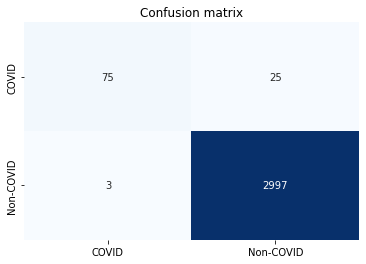

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

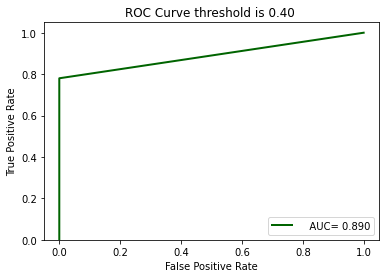

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 29
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  73
total cases that predicted as non covid : 3027
Sensitivity is : 0.71
Specificity is : 0.9993333333333333


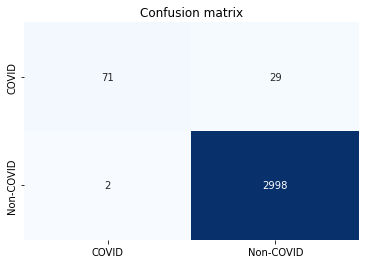

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

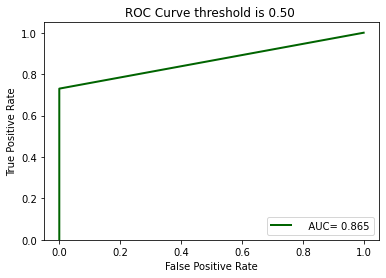

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **3rd ResNet50**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet50(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        if i >= 7 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet50_100_3.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 1.000 


preds: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 1.000 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet50_100_3.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experiments**

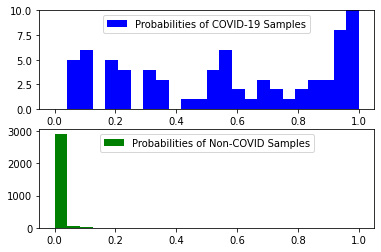

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 0
num of samples non covid but predicted covid : 103
total cases that predicted as covid:  203
total cases that predicted as non covid : 2897
Sensitivity is : 1.0
Specificity is : 0.9656666666666667


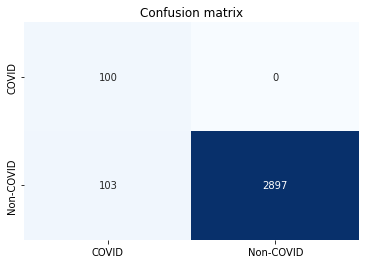

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

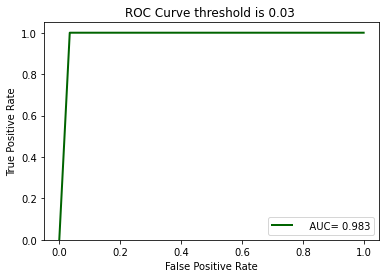

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 29
total cases that predicted as covid:  121
total cases that predicted as non covid : 2979
Sensitivity is : 0.92
Specificity is : 0.9903333333333333


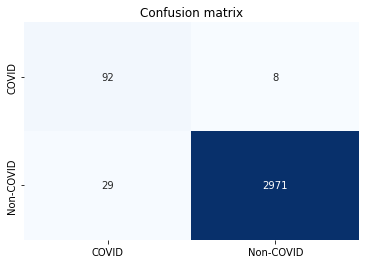

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

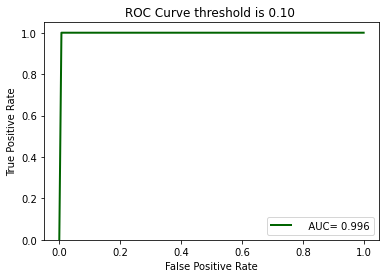

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 18
total cases that predicted as covid:  107
total cases that predicted as non covid : 2993
Sensitivity is : 0.89
Specificity is : 0.994


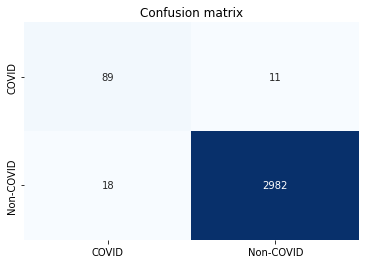

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

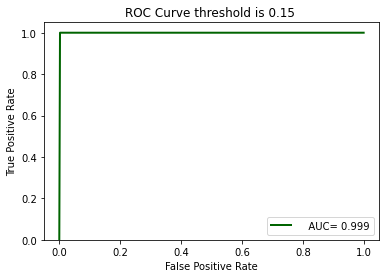

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 15
total cases that predicted as covid:  104
total cases that predicted as non covid : 2996
Sensitivity is : 0.89
Specificity is : 0.995


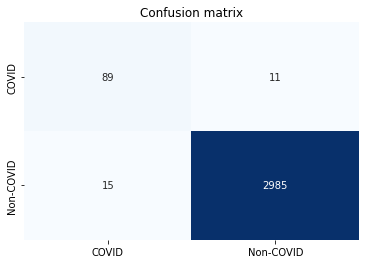

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

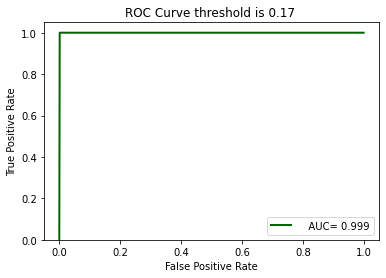

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 14
num of samples non covid but predicted covid : 12
total cases that predicted as covid:  98
total cases that predicted as non covid : 3002
Sensitivity is : 0.86
Specificity is : 0.996


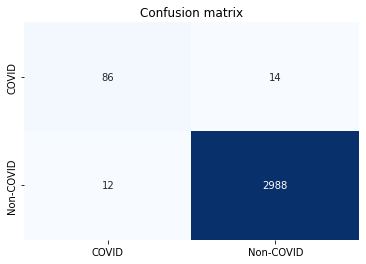

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

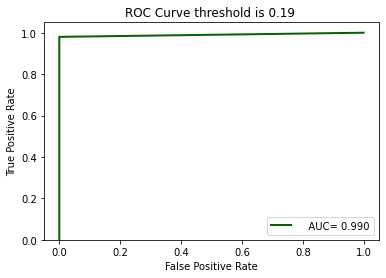

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.20**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 16
num of samples non covid but predicted covid : 11
total cases that predicted as covid:  95
total cases that predicted as non covid : 3005
Sensitivity is : 0.84
Specificity is : 0.9963333333333333


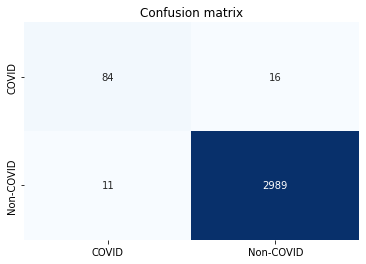

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

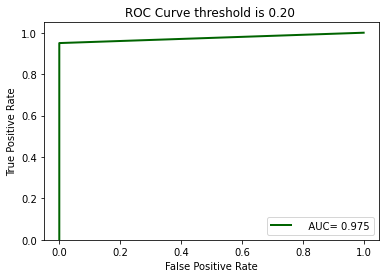

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 20
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  86
total cases that predicted as non covid : 3014
Sensitivity is : 0.8
Specificity is : 0.998


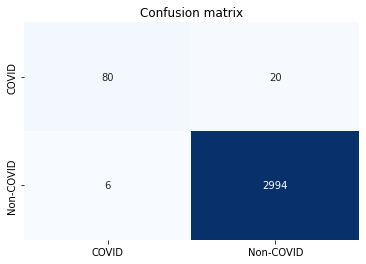

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

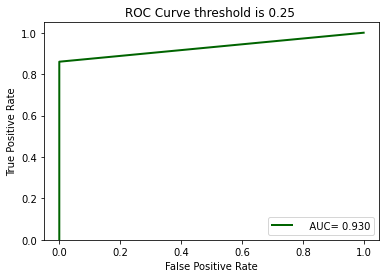

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.30**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.78
Specificity is : 0.9993333333333333


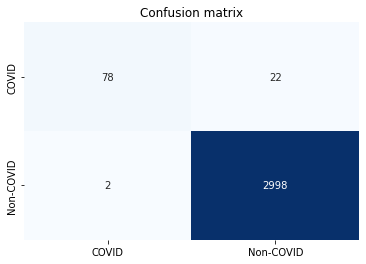

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

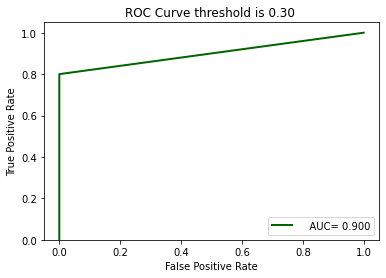

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  77
total cases that predicted as non covid : 3023
Sensitivity is : 0.75
Specificity is : 0.9993333333333333


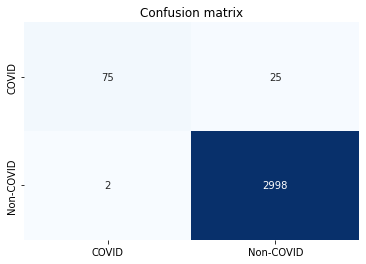

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

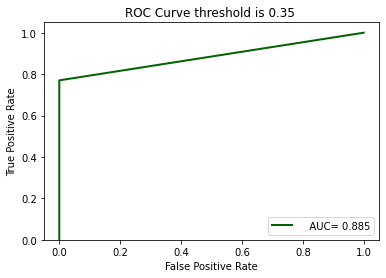

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.40**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 27
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  75
total cases that predicted as non covid : 3025
Sensitivity is : 0.73
Specificity is : 0.9993333333333333


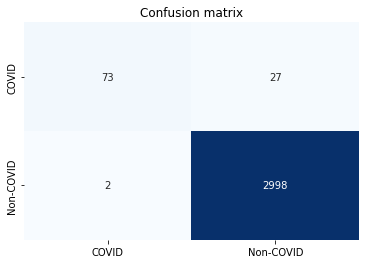

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

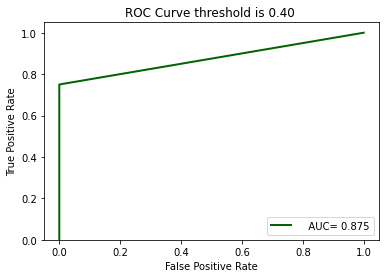

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.50**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 29
num of samples non covid but predicted covid : 1
total cases that predicted as covid:  72
total cases that predicted as non covid : 3028
Sensitivity is : 0.71
Specificity is : 0.9996666666666667


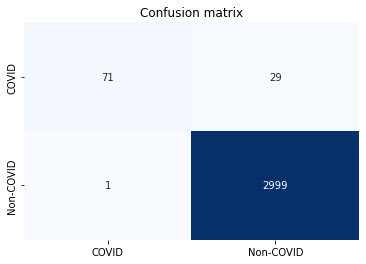

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

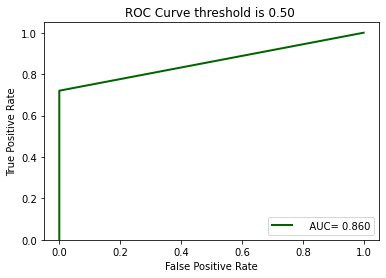

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **DenseNet 121**

## **Code**

In [ ]:
#### load model
from torchsummary import summary
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_densnet121_epoch100.pt')







Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
preds: tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.800 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
  

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_densnet121_epoch100.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experiment**

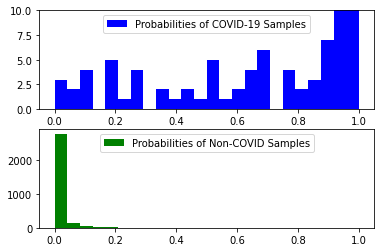

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 2
num of samples non covid but predicted covid : 322
total cases that predicted as covid:  420
total cases that predicted as non covid : 2680
Sensitivity is : 0.98
Specificity is : 0.8926666666666667


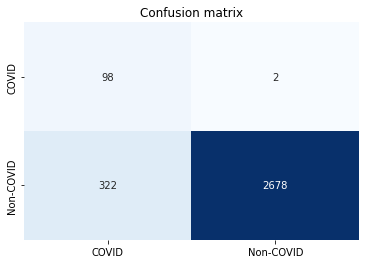

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

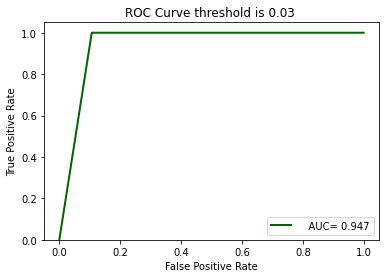

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 77
total cases that predicted as covid:  171
total cases that predicted as non covid : 2929
Sensitivity is : 0.94
Specificity is : 0.9743333333333334


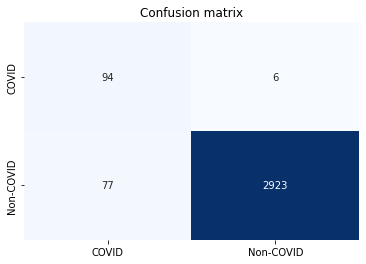

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

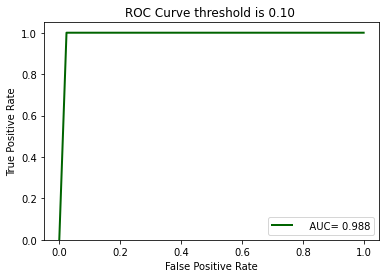

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 46
total cases that predicted as covid:  137
total cases that predicted as non covid : 2963
Sensitivity is : 0.91
Specificity is : 0.9846666666666667


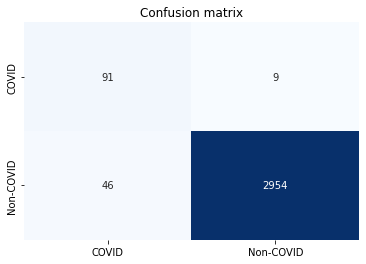

In [ ]:
rob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

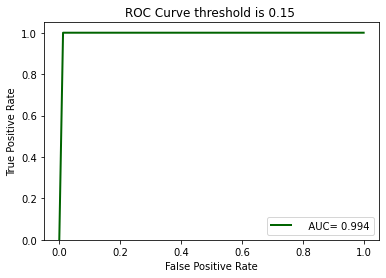

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 34
total cases that predicted as covid:  124
total cases that predicted as non covid : 2976
Sensitivity is : 0.9
Specificity is : 0.9886666666666667


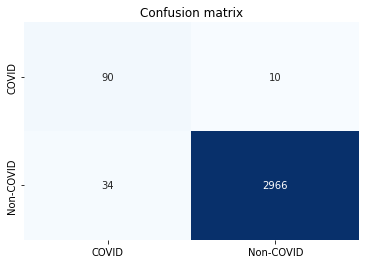

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

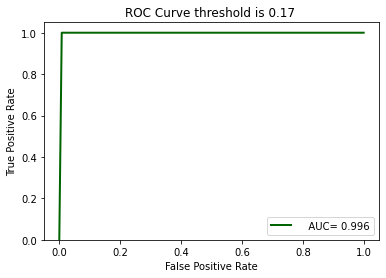

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 13
num of samples non covid but predicted covid : 29
total cases that predicted as covid:  116
total cases that predicted as non covid : 2984
Sensitivity is : 0.87
Specificity is : 0.9903333333333333


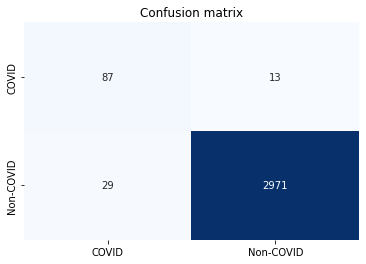

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

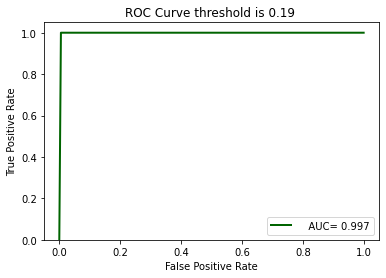

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 14
num of samples non covid but predicted covid : 26
total cases that predicted as covid:  112
total cases that predicted as non covid : 2988
Sensitivity is : 0.86
Specificity is : 0.9913333333333333


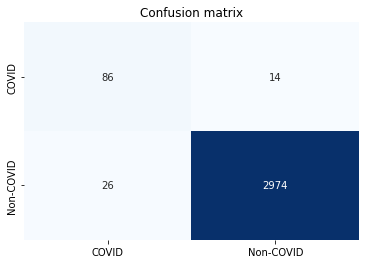

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

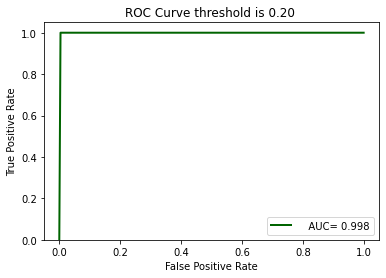

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 16
total cases that predicted as covid:  101
total cases that predicted as non covid : 2999
Sensitivity is : 0.85
Specificity is : 0.9946666666666667


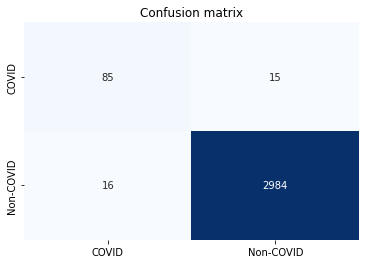

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

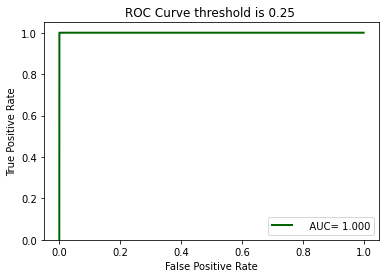

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.25)

### **Threshold = 0.30**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 12
total cases that predicted as covid:  93
total cases that predicted as non covid : 3007
Sensitivity is : 0.81
Specificity is : 0.996


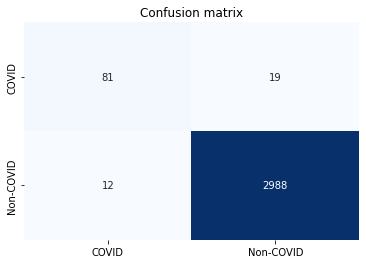

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

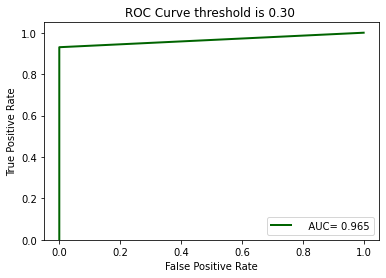

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  87
total cases that predicted as non covid : 3013
Sensitivity is : 0.79
Specificity is : 0.9973333333333333


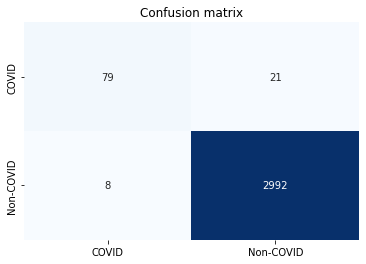

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

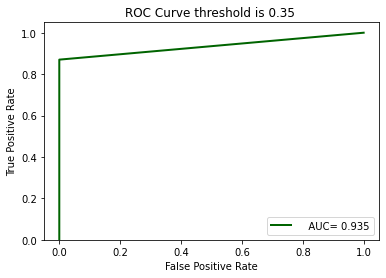

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.78
Specificity is : 0.9976666666666667


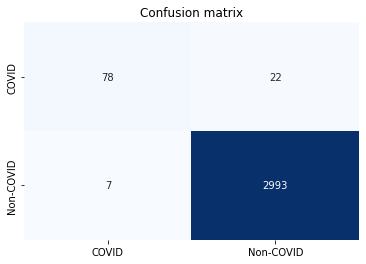

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

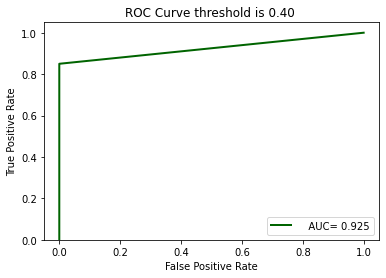

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 3
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.75
Specificity is : 0.999


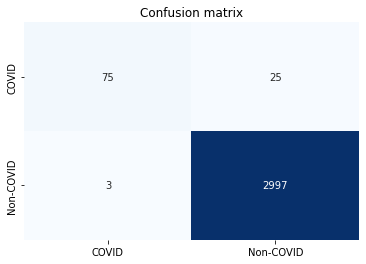

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

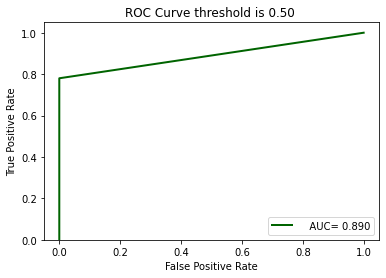

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.5)

# **2nd DensNet 121**

## **code**

In [ ]:
#### load model
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
for param in model_conv.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True
for param in model_conv.features.norm5.parameters():
    param.requires_grad = True
        
        

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_densnet121_epoch100_2.pt')




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 1.000 

In [ ]:
 model_conv

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_densnet121_epoch100_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experimnet**

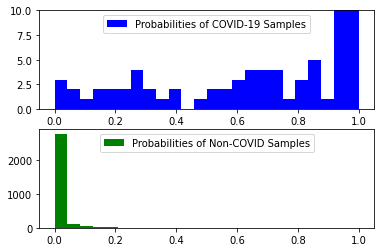

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 3
num of samples non covid but predicted covid : 308
total cases that predicted as covid:  405
total cases that predicted as non covid : 2695
Sensitivity is : 0.97
Specificity is : 0.8973333333333333


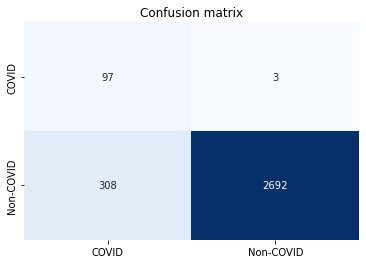

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

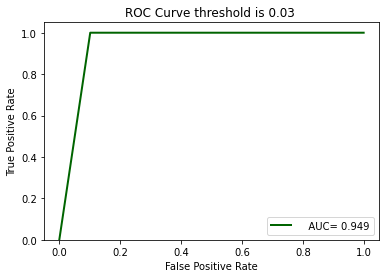

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 78
total cases that predicted as covid:  172
total cases that predicted as non covid : 2928
Sensitivity is : 0.94
Specificity is : 0.974


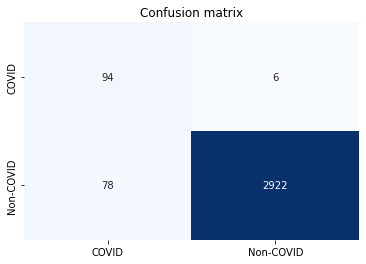

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

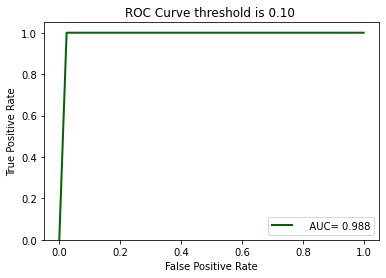

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 7
num of samples non covid but predicted covid : 42
total cases that predicted as covid:  135
total cases that predicted as non covid : 2965
Sensitivity is : 0.93
Specificity is : 0.986


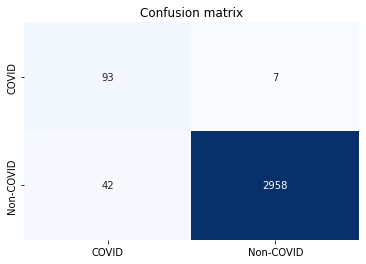

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

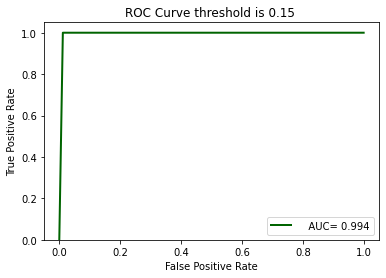

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 36
total cases that predicted as covid:  128
total cases that predicted as non covid : 2972
Sensitivity is : 0.92
Specificity is : 0.988


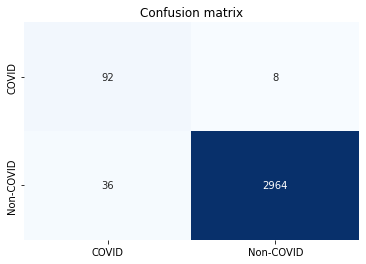

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

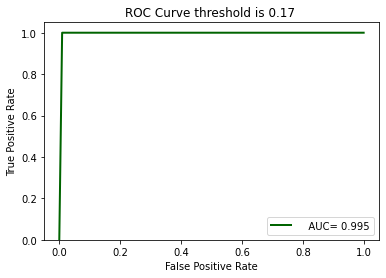

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 31
total cases that predicted as covid:  122
total cases that predicted as non covid : 2978
Sensitivity is : 0.91
Specificity is : 0.9896666666666667


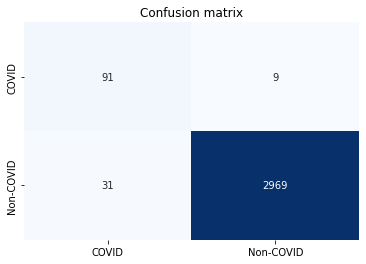

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

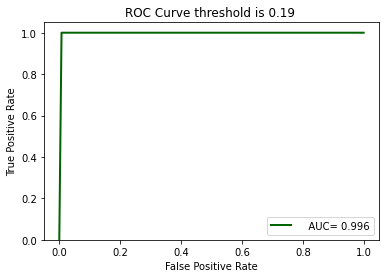

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 27
total cases that predicted as covid:  117
total cases that predicted as non covid : 2983
Sensitivity is : 0.9
Specificity is : 0.991


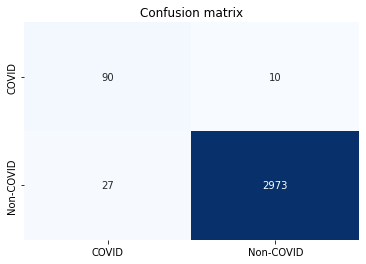

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

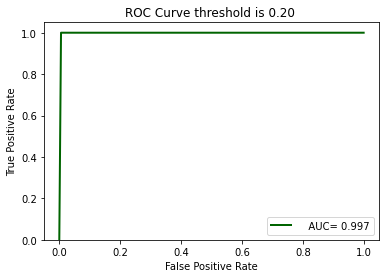

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 12
num of samples non covid but predicted covid : 19
total cases that predicted as covid:  107
total cases that predicted as non covid : 2993
Sensitivity is : 0.88
Specificity is : 0.9936666666666667


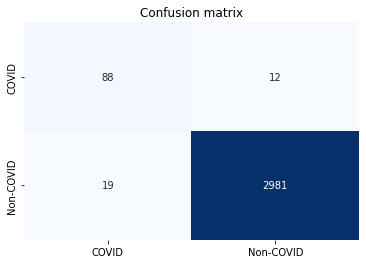

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

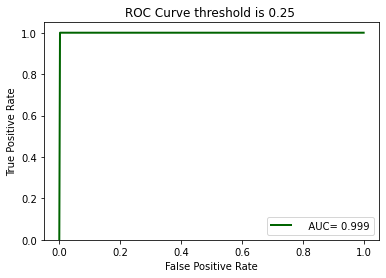

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 16
num of samples non covid but predicted covid : 12
total cases that predicted as covid:  96
total cases that predicted as non covid : 3004
Sensitivity is : 0.84
Specificity is : 0.996


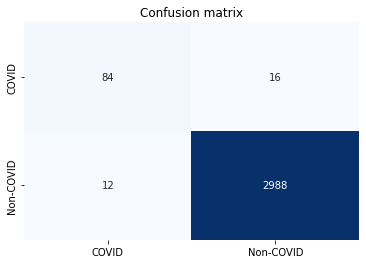

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

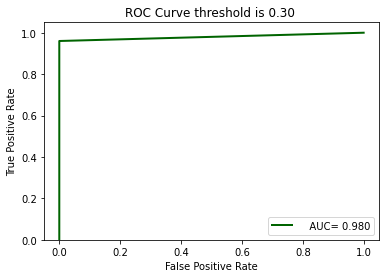

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  90
total cases that predicted as non covid : 3010
Sensitivity is : 0.81
Specificity is : 0.997


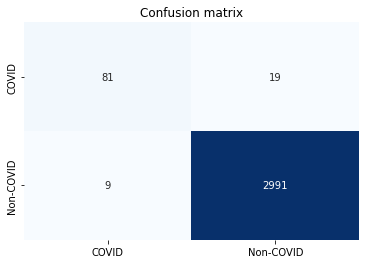

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

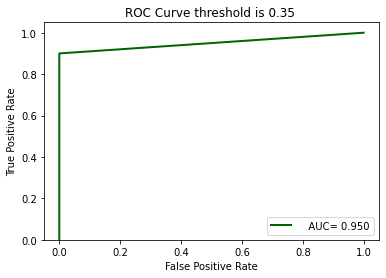

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.79
Specificity is : 0.997


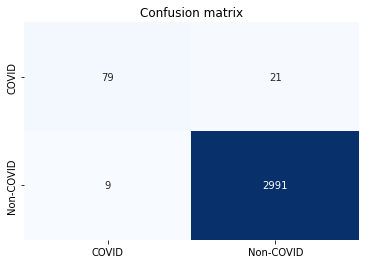

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

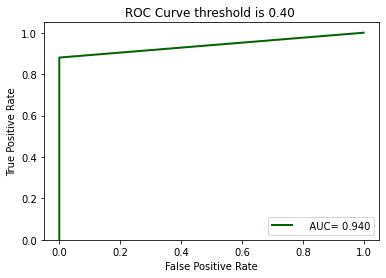

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 5
total cases that predicted as covid:  83
total cases that predicted as non covid : 3017
Sensitivity is : 0.78
Specificity is : 0.9983333333333333


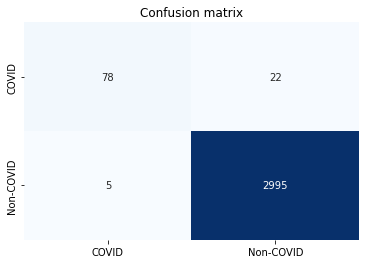

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

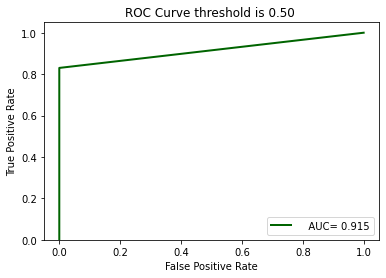

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **3rd DenseNet 121**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
for param in model_conv.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True
for param in model_conv.features.denseblock4.denselayer15.parameters():
    param.requires_grad = True
for param in model_conv.features.norm5.parameters():
    param.requires_grad = True
        
        

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_densnet121_epoch100_3.pt')




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
label: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.900 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 0.950 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_densnet121_epoch100_3.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experiment**

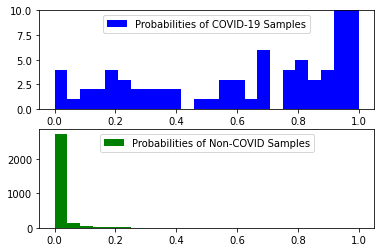

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 2
num of samples non covid but predicted covid : 334
total cases that predicted as covid:  432
total cases that predicted as non covid : 2668
Sensitivity is : 0.98
Specificity is : 0.8886666666666667


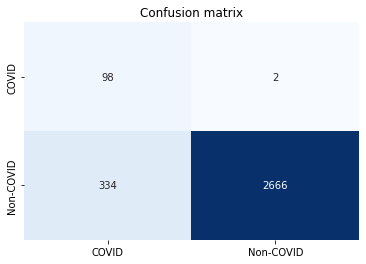

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

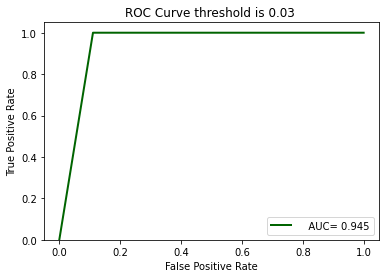

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 88
total cases that predicted as covid:  182
total cases that predicted as non covid : 2918
Sensitivity is : 0.94
Specificity is : 0.9706666666666667


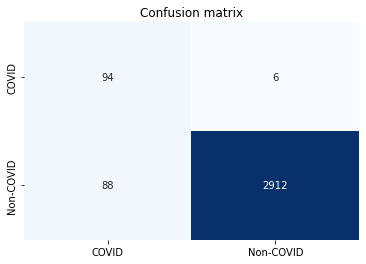

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

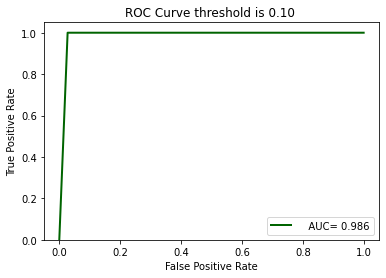

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 49
total cases that predicted as covid:  141
total cases that predicted as non covid : 2959
Sensitivity is : 0.92
Specificity is : 0.9836666666666667


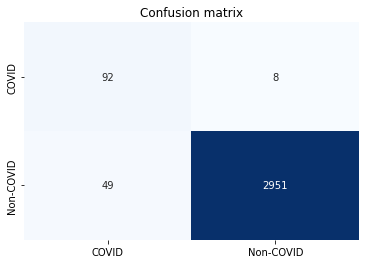

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

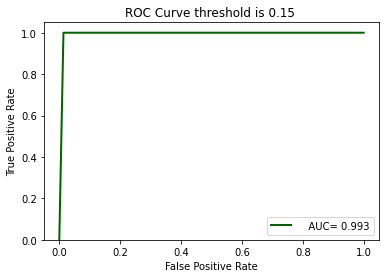

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 41
total cases that predicted as covid:  132
total cases that predicted as non covid : 2968
Sensitivity is : 0.91
Specificity is : 0.9863333333333333


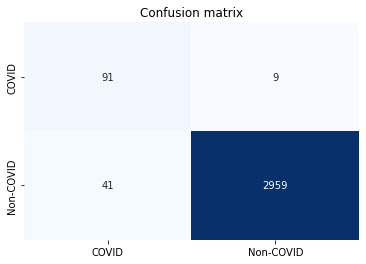

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

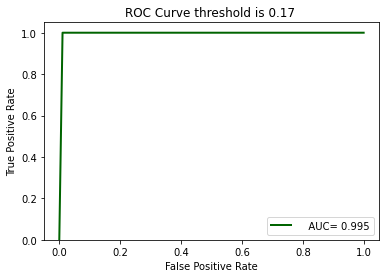

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 32
total cases that predicted as covid:  121
total cases that predicted as non covid : 2979
Sensitivity is : 0.89
Specificity is : 0.9893333333333333


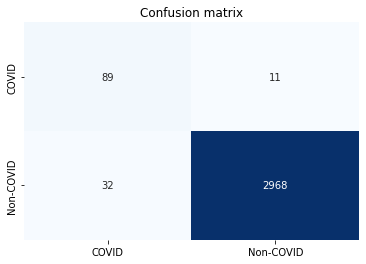

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

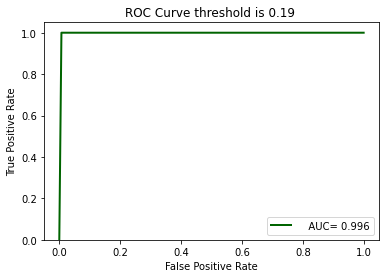

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 30
total cases that predicted as covid:  119
total cases that predicted as non covid : 2981
Sensitivity is : 0.89
Specificity is : 0.99


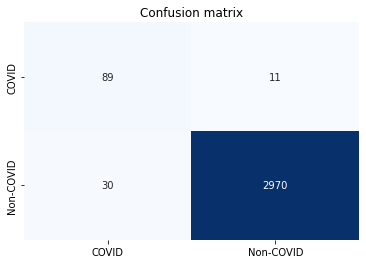

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

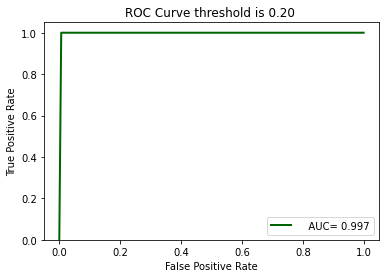

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 16
num of samples non covid but predicted covid : 19
total cases that predicted as covid:  103
total cases that predicted as non covid : 2997
Sensitivity is : 0.84
Specificity is : 0.9936666666666667


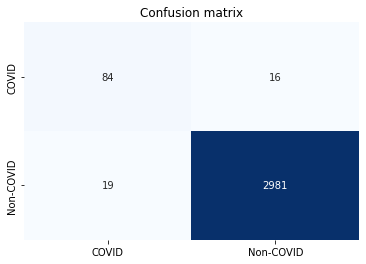

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

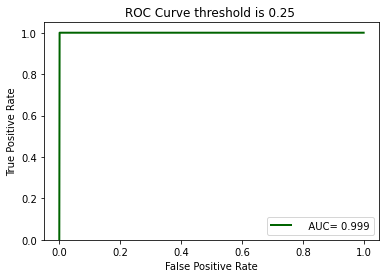

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 16
total cases that predicted as covid:  98
total cases that predicted as non covid : 3002
Sensitivity is : 0.82
Specificity is : 0.9946666666666667


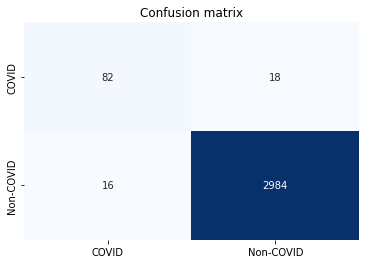

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

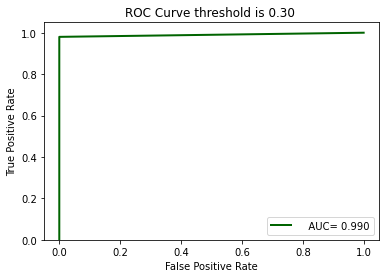

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 12
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.79
Specificity is : 0.996


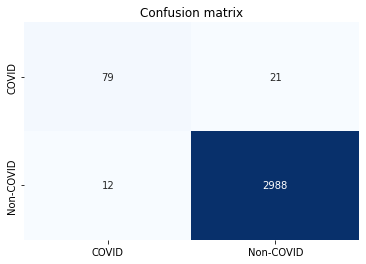

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

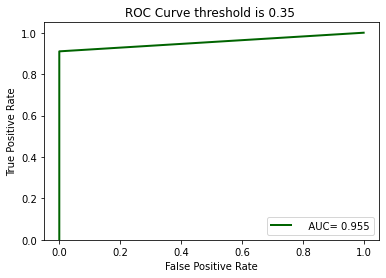

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.77
Specificity is : 0.9973333333333333


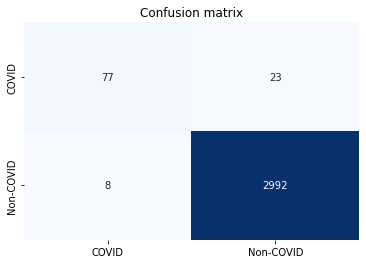

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

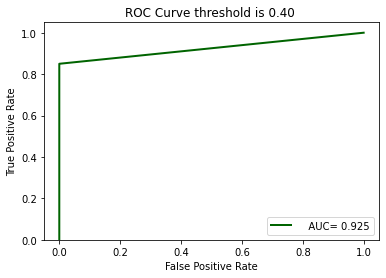

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 25
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  79
total cases that predicted as non covid : 3021
Sensitivity is : 0.75
Specificity is : 0.9986666666666667


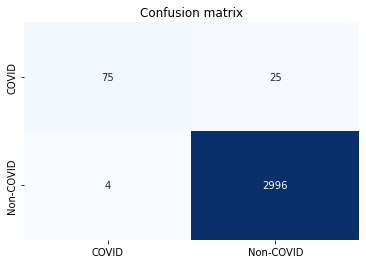

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

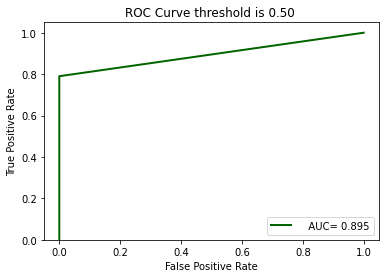

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **Squeeznet**

## **Code**

In [ ]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
# num_ftrs = model_conv.classifier.in_features        
model_conv.classifier =nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 2, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_squeznetepoch100.pt')






Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/100
----------

preds: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
1-th epoch, 1-th batch (size=20), train acc= 0.850 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Streaming output truncated to the last 5000 lines.
preds: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
  

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_squeznetepoch100.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']
class_names2 =  ['non','covid']

## **Experiment**

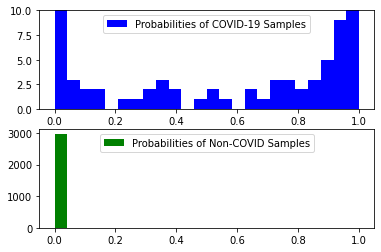

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 24
total cases that predicted as covid:  114
total cases that predicted as non covid : 2986
Sensitivity is : 0.9
Specificity is : 0.992
CPU times: user 5min 38s, sys: 12.7 s, total: 5min 51s
Wall time: 6min 1s


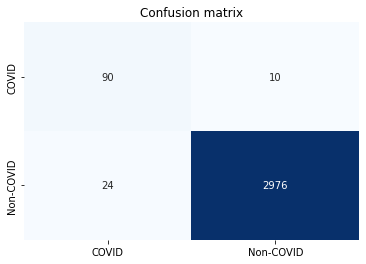

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

CPU times: user 18.1 ms, sys: 1.07 ms, total: 19.2 ms
Wall time: 18.8 ms


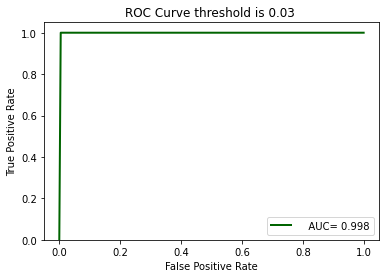

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 14
num of samples non covid but predicted covid : 11
total cases that predicted as covid:  97
total cases that predicted as non covid : 3003
Sensitivity is : 0.86
Specificity is : 0.9963333333333333
CPU times: user 5min 39s, sys: 9.7 s, total: 5min 48s
Wall time: 11min 18s


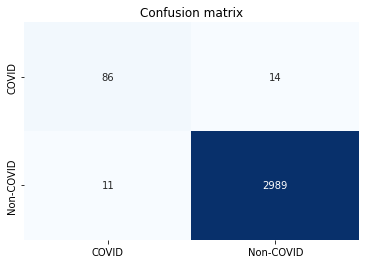

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

CPU times: user 26.8 ms, sys: 1.94 ms, total: 28.8 ms
Wall time: 30.5 ms


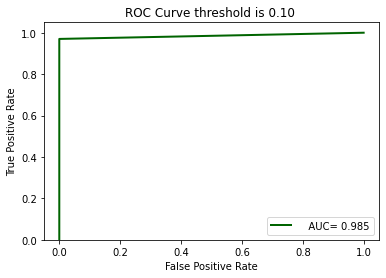

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.83
Specificity is : 0.9973333333333333
CPU times: user 5min 27s, sys: 14 s, total: 5min 41s
Wall time: 5min 47s


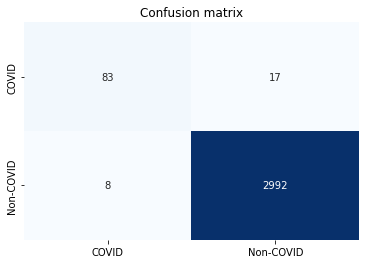

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

CPU times: user 18.5 ms, sys: 1.02 ms, total: 19.5 ms
Wall time: 19.2 ms


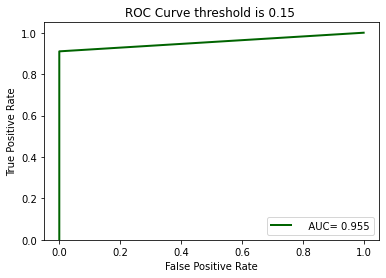

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.82
Specificity is : 0.998
CPU times: user 5min 30s, sys: 14.1 s, total: 5min 44s
Wall time: 5min 50s


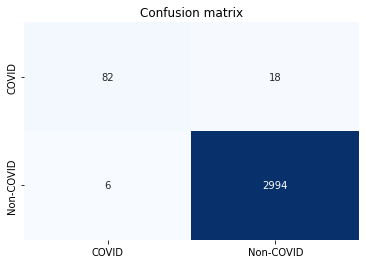

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

CPU times: user 17.7 ms, sys: 1.99 ms, total: 19.7 ms
Wall time: 20.6 ms


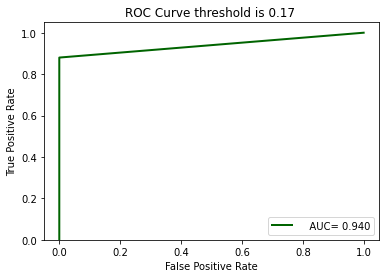

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  86
total cases that predicted as non covid : 3014
Sensitivity is : 0.82
Specificity is : 0.9986666666666667
CPU times: user 5min 35s, sys: 14.5 s, total: 5min 50s
Wall time: 5min 56s


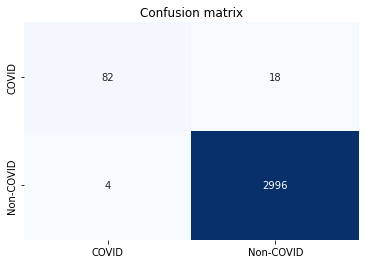

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

CPU times: user 21.6 ms, sys: 984 µs, total: 22.6 ms
Wall time: 27.8 ms


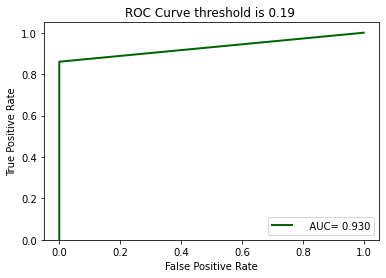

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  86
total cases that predicted as non covid : 3014
Sensitivity is : 0.82
Specificity is : 0.9986666666666667
CPU times: user 5min 30s, sys: 15.9 s, total: 5min 46s
Wall time: 5min 52s


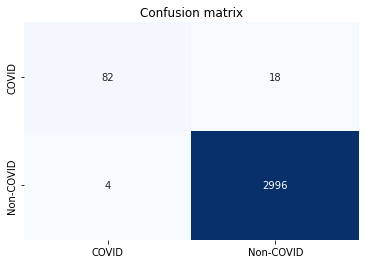

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

CPU times: user 20.3 ms, sys: 3.93 ms, total: 24.2 ms
Wall time: 24.1 ms


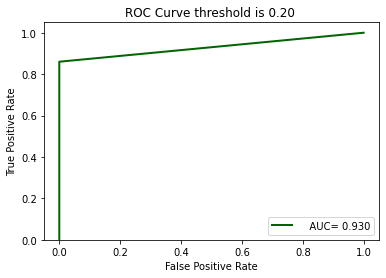

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 19
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.81
Specificity is : 0.9986666666666667
CPU times: user 5min 28s, sys: 17.1 s, total: 5min 45s
Wall time: 5min 51s


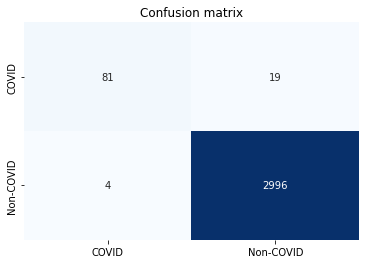

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

CPU times: user 19.2 ms, sys: 967 µs, total: 20.2 ms
Wall time: 19.7 ms


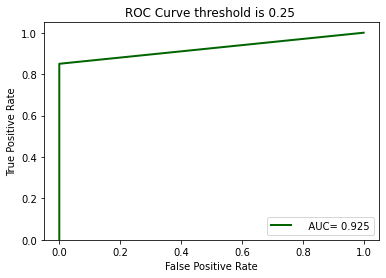

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 20
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  84
total cases that predicted as non covid : 3016
Sensitivity is : 0.8
Specificity is : 0.9986666666666667
CPU times: user 5min 27s, sys: 17.2 s, total: 5min 44s
Wall time: 5min 50s


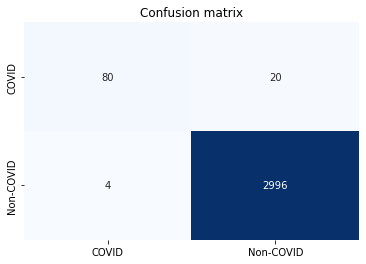

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

CPU times: user 16.9 ms, sys: 2.96 ms, total: 19.8 ms
Wall time: 19.3 ms


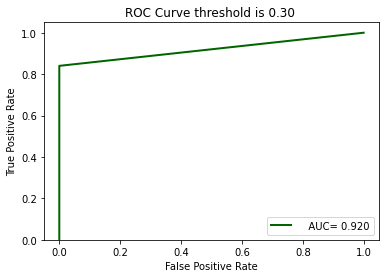

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 24
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.76
Specificity is : 0.9986666666666667
CPU times: user 5min 39s, sys: 16.6 s, total: 5min 55s
Wall time: 6min 5s


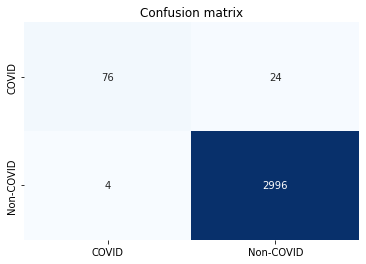

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

CPU times: user 20.2 ms, sys: 3.97 ms, total: 24.2 ms
Wall time: 29.6 ms


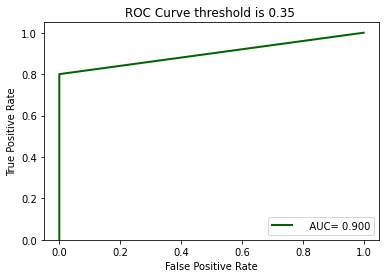

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 26
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.74
Specificity is : 0.9986666666666667
CPU times: user 5min 32s, sys: 15.4 s, total: 5min 47s
Wall time: 5min 53s


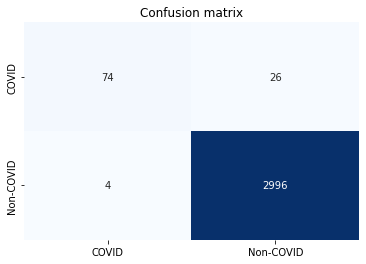

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

CPU times: user 24 ms, sys: 2 ms, total: 26 ms
Wall time: 24.2 ms


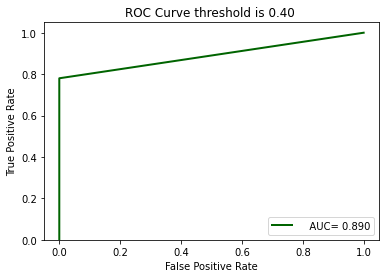

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 28
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  74
total cases that predicted as non covid : 3026
Sensitivity is : 0.72
Specificity is : 0.9993333333333333
CPU times: user 5min 19s, sys: 15.2 s, total: 5min 35s
Wall time: 30min 6s


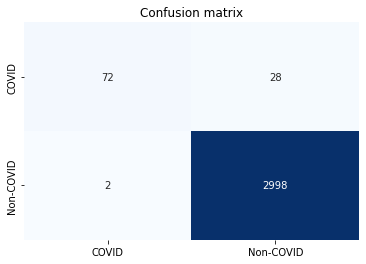

In [ ]:
%%time
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

CPU times: user 20.7 ms, sys: 935 µs, total: 21.6 ms
Wall time: 22.9 ms


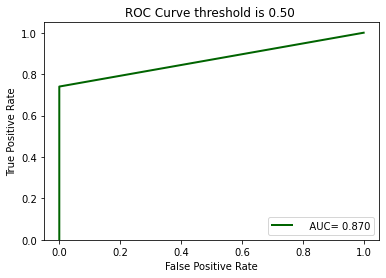

In [ ]:
%%time
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred,0.5)

# **2nd Squeeznet**

## **Code**

In [ ]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.features[12].parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default   
# num_ftrs = model_conv.classifier.in_features        
model_conv.classifier =nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 2, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_squeznetepoch100_2.pt')




Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Streaming output truncated to the last 5000 lines.
preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.950 


preds: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
  

In [ ]:
model_conv

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_squeznetepoch100_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experiment**

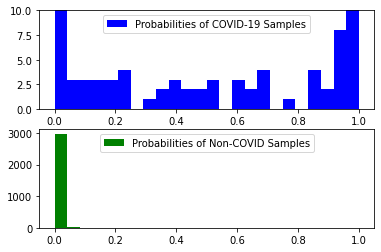

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 25
total cases that predicted as covid:  114
total cases that predicted as non covid : 2986
Sensitivity is : 0.89
Specificity is : 0.9916666666666667


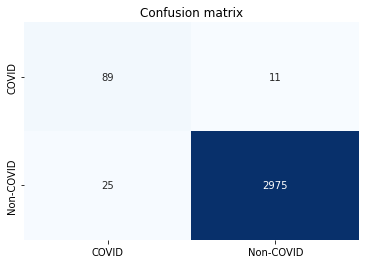

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

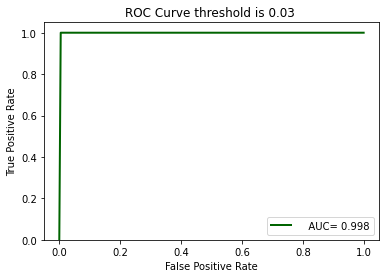

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 13
total cases that predicted as covid:  96
total cases that predicted as non covid : 3004
Sensitivity is : 0.83
Specificity is : 0.9956666666666667


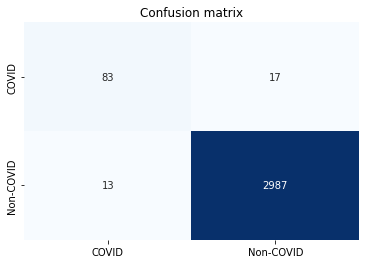

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

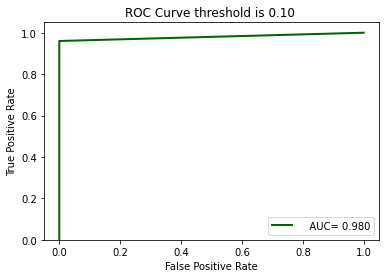

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.82
Specificity is : 0.997


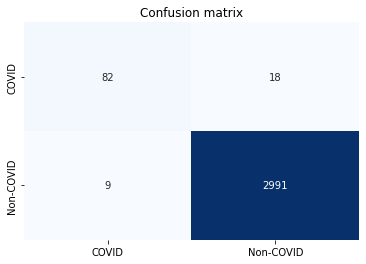

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

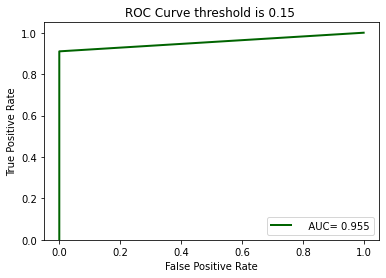

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.79
Specificity is : 0.997


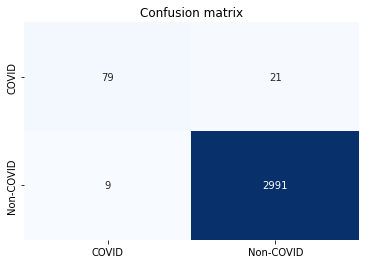

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

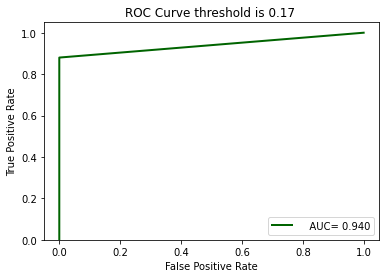

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  87
total cases that predicted as non covid : 3013
Sensitivity is : 0.78
Specificity is : 0.997


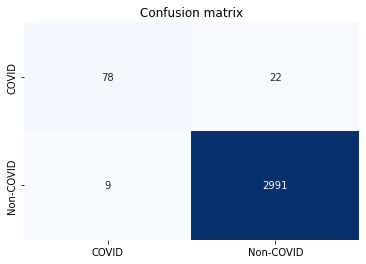

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

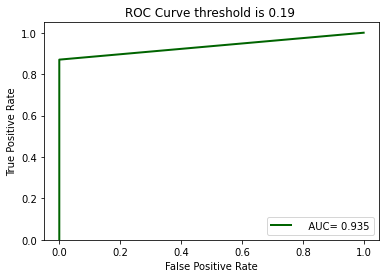

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.77
Specificity is : 0.9973333333333333


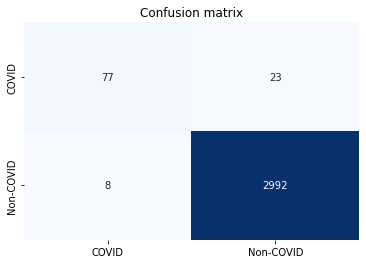

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

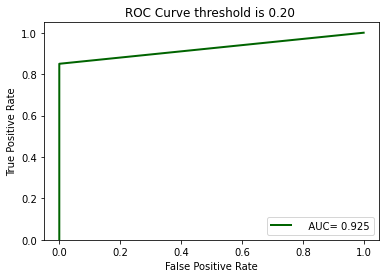

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 27
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.73
Specificity is : 0.9976666666666667


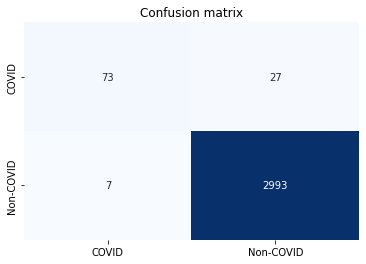

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

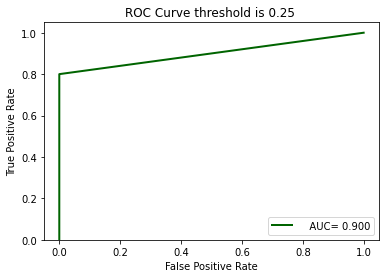

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 27
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  79
total cases that predicted as non covid : 3021
Sensitivity is : 0.73
Specificity is : 0.998


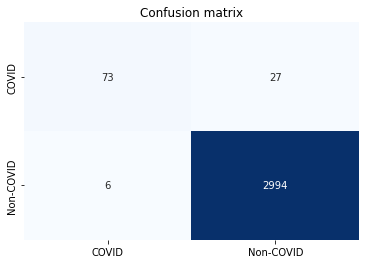

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

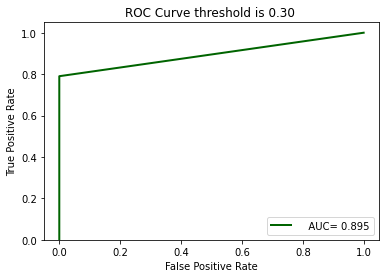

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 30
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  76
total cases that predicted as non covid : 3024
Sensitivity is : 0.7
Specificity is : 0.998


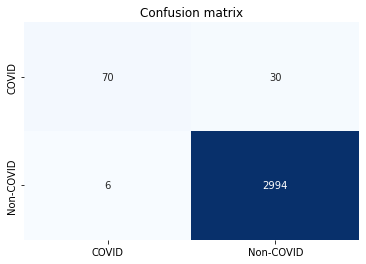

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

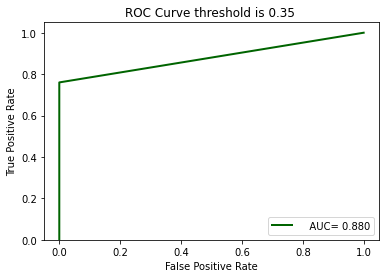

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 33
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  73
total cases that predicted as non covid : 3027
Sensitivity is : 0.67
Specificity is : 0.998


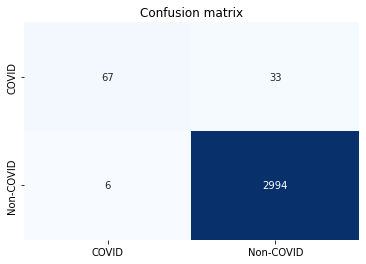

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

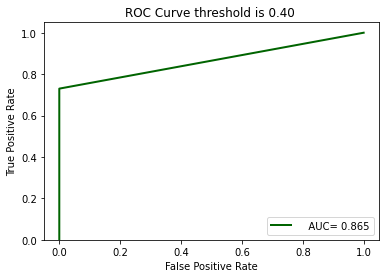

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 37
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  65
total cases that predicted as non covid : 3035
Sensitivity is : 0.63
Specificity is : 0.9993333333333333


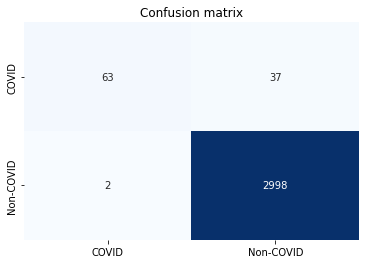

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

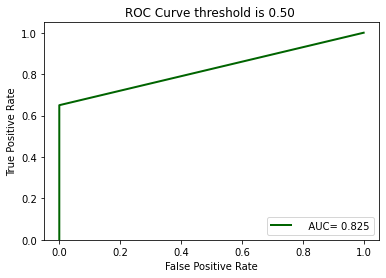

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **3rd Squeeznet**

## **Code**

In [ ]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.features[12].parameters():
    param.requires_grad = True
for param in model_conv.features[11].parameters():
    param.requires_grad = True
for param in model_conv.features[10].parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default   
# num_ftrs = model_conv.classifier.in_features        
model_conv.classifier =nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 2, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)2
    model_conv.eval()
    torch.save(model_conv, './covid_squeznetepoch100_3.pt')





Epoch 1/100
----------

preds: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
1-th epoch, 1-th batch (size=20), train acc= 0.450 



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Streaming output truncated to the last 5000 lines.
preds: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.950 


preds: tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       device='cuda:0')
label: tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_squeznetepoch100_3.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']

## **Experiment**

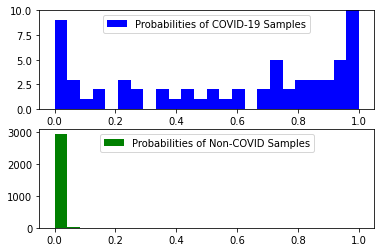

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 54
total cases that predicted as covid:  146
total cases that predicted as non covid : 2954
Sensitivity is : 0.92
Specificity is : 0.982


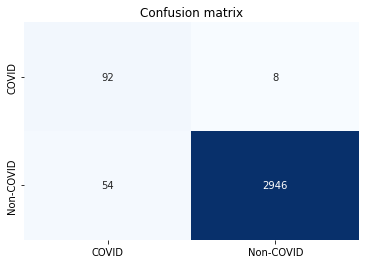

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

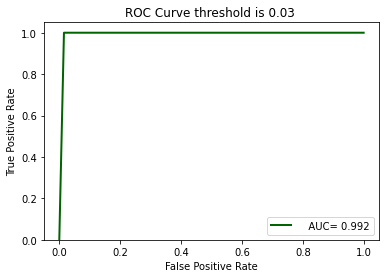

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 12
num of samples non covid but predicted covid : 20
total cases that predicted as covid:  108
total cases that predicted as non covid : 2992
Sensitivity is : 0.88
Specificity is : 0.9933333333333333


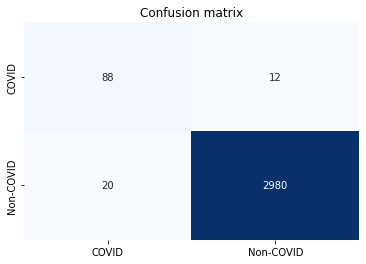

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

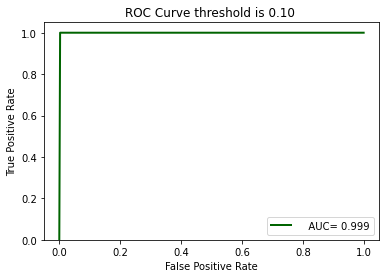

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 14
num of samples non covid but predicted covid : 17
total cases that predicted as covid:  103
total cases that predicted as non covid : 2997
Sensitivity is : 0.86
Specificity is : 0.9943333333333333


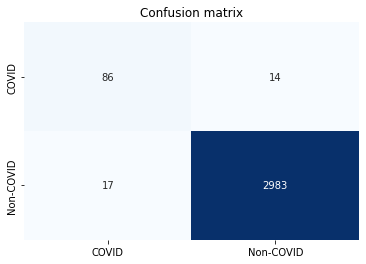

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

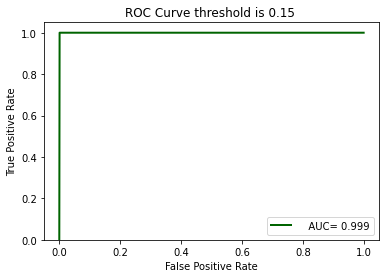

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 17
total cases that predicted as covid:  102
total cases that predicted as non covid : 2998
Sensitivity is : 0.85
Specificity is : 0.9943333333333333


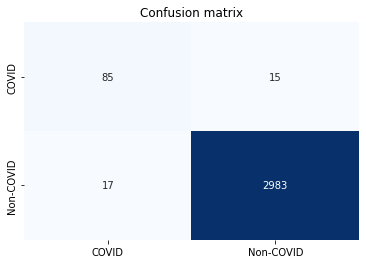

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

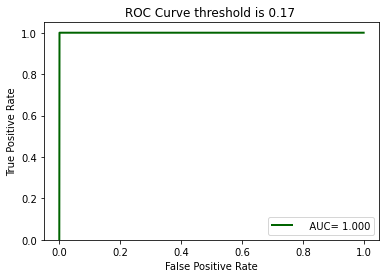

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 14
total cases that predicted as covid:  99
total cases that predicted as non covid : 3001
Sensitivity is : 0.85
Specificity is : 0.9953333333333333


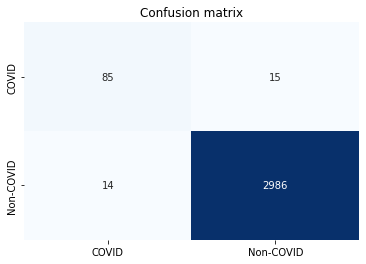

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

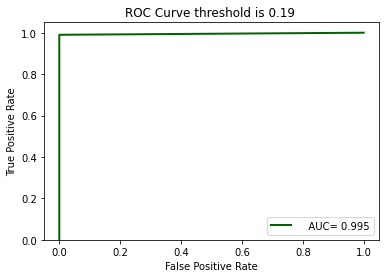

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 13
total cases that predicted as covid:  98
total cases that predicted as non covid : 3002
Sensitivity is : 0.85
Specificity is : 0.9956666666666667


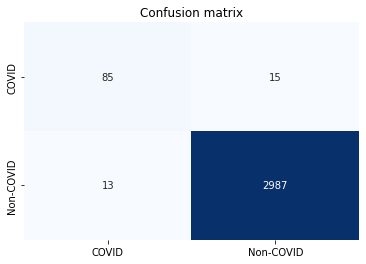

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

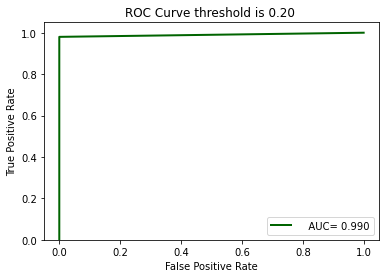

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 10
total cases that predicted as covid:  92
total cases that predicted as non covid : 3008
Sensitivity is : 0.82
Specificity is : 0.9966666666666667


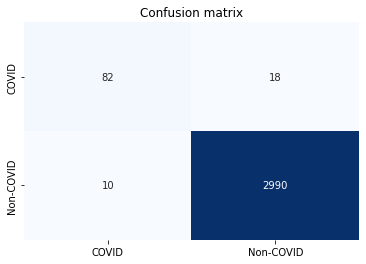

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

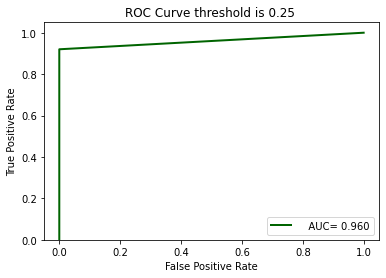

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 20
num of samples non covid but predicted covid : 10
total cases that predicted as covid:  90
total cases that predicted as non covid : 3010
Sensitivity is : 0.8
Specificity is : 0.9966666666666667


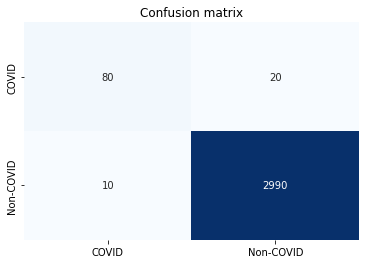

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

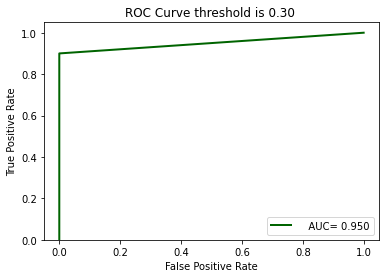

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  85
total cases that predicted as non covid : 3015
Sensitivity is : 0.79
Specificity is : 0.998


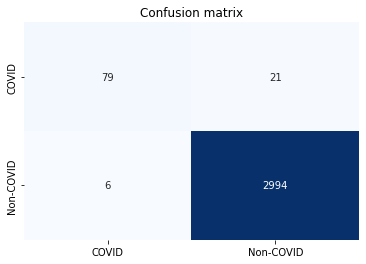

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

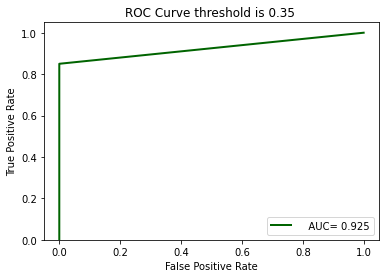

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 23
num of samples non covid but predicted covid : 5
total cases that predicted as covid:  82
total cases that predicted as non covid : 3018
Sensitivity is : 0.77
Specificity is : 0.9983333333333333


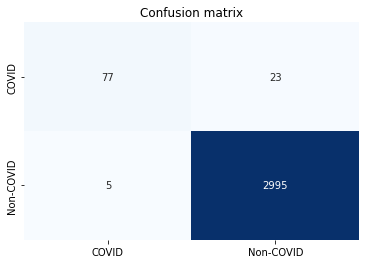

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

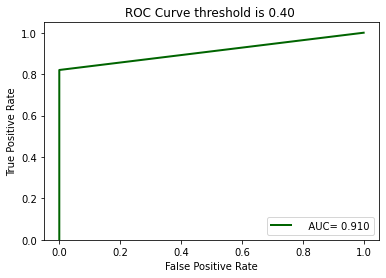

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 26
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  78
total cases that predicted as non covid : 3022
Sensitivity is : 0.74
Specificity is : 0.9986666666666667


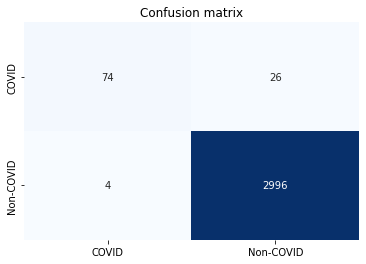

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

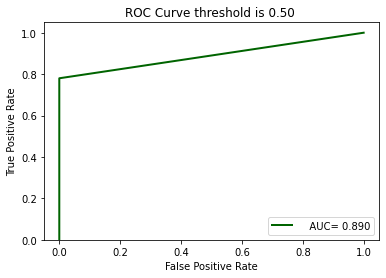

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)